# Workflow for measuring Si/Ge nanowire using either DC current sensing or reflectometry readout

## Set-up the experimental framework

### Import section

In [1]:
# %matplotlib qt
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from pprint import pprint
from time import sleep
from importlib import reload

# qcodes imports
import qcodes as qc
from qcodes import (initialise_or_create_database_at,
                    load_or_create_experiment,
                    ManualParameter)
from qcodes.utils.dataset.doNd import do1d, do2d, do0d
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter, ScaledParameter

# Import instrument drivers
from qualang_tools.external_frameworks.qcodes.opx_driver import OPX
from qcodes_contrib_drivers.drivers.QDevil import QDAC2

# Import OPX packages
from qm.qua import *
from qualang_tools.addons.variables import assign_variables_to_element
from qualang_tools.loops import from_array
from qualang_tools.units import unit 
from set_octave import *
from configuration import *
u = unit(coerce_to_integer=True)

2023-10-17 17:15:08,234 - qm - INFO     - Starting session: 932f90d5-8577-4ef0-a1ad-0b3bd9d77ed0


In [2]:
import time
from typing import Dict, Optional

from qcodes import (
    Instrument,
    Parameter,
    MultiParameter,
)
from qcodes.utils.validators import Numbers, Arrays
from qm import SimulationConfig
from qm.qua import program
from qm.QuantumMachinesManager import QuantumMachinesManager
from qualang_tools.results import wait_until_job_is_paused
from qualang_tools.results import fetching_tool
from qualang_tools.plot import interrupt_on_close
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

class OPX(Instrument):
    def __init__(
        self,
        config: Dict,
        name: str = "OPX",
        host: str = None,
        port: int = None,
        cluster_name: str = None,
        octave=None,
        close_other_machines: bool = True,
    ) -> None:
        """
        QCoDeS driver for the OPX.

        :param config: python dict containing the configuration expected by the OPX.
        :param name: The name of the instrument used internally by QCoDeS. Must be unique.
        :param host: IP address of the router to which the OPX is connected.
        :param cluster_name: Name of the cluster as defined in the OPX admin panel (from version QOP220)
        :param port: Port of the OPX or main OPX if working with a cluster.
        :param octave: Octave configuration if an Octave is to be used in this experiment.
        :param close_other_machines: Flag to control if opening a quantum machine will close the existing ones. Default is True. Set to False if multiple a QOP is to be used by multiple users or to run several experiments in parallel.
        """
        super().__init__(name)

        self.qm = None
        self.qm_id = None
        self.qmm = None
        self.close_other_machines = close_other_machines
        self.config = None
        self.result_handles = None
        self.job = None
        self.counter = 0
        self.results = {"names": [], "types": [], "buffers": [], "units": []}
        self.prog_id = None
        self.simulated_wf = {}
        # Parameter for simulation duration
        self.add_parameter(
            "sim_time",
            unit="ns",
            label="sim_time",
            initial_value=100000,
            vals=Numbers(
                4,
            ),
            get_cmd=None,
            set_cmd=None,
        )
        self.measurement_variables = None
        self.add_parameter(
            "readout_pulse_length",
            unit="ns",
            vals=Numbers(16, 1e7),
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis1_stop",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis1_start",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis1_step",
            unit="",
            initial_value=0.1,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis1_npoints",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis1_full_list",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis1_axis",
            unit="",
            label="Axis 1",
            parameter_class=GeneratedSetPointsArbitrary,
            full_list=self.axis1_full_list,
            vals=Arrays(shape=(self.axis1_npoints.get_latest,)),
        )
        self.add_parameter(
            "axis2_stop",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis2_start",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis2_step",
            unit="",
            initial_value=0.1,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis2_npoints",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis2_full_list",
            unit="",
            initial_value=0,
            get_cmd=None,
            set_cmd=None,
        )
        self.add_parameter(
            "axis2_axis",
            unit="",
            label="Axis 2",
            parameter_class=GeneratedSetPointsArbitrary,
            full_list=self.axis2_full_list,
            vals=Arrays(shape=(self.axis1_npoints.get_latest,)),
        )
        # Open QMM
        self.connect_to_qmm(
            host=host, port=port, cluster_name=cluster_name, octave=octave
        )
        # Set config
        self.set_config(config=config)
        # Open QM
        self.open_qm(close_other_machines)

    def connect_to_qmm(
        self, host: str = None, port: int = None, cluster_name: str = None, octave=None
    ):
        """
        Enable the connection with the OPX by creating the QuantumMachineManager.
        Displays the connection message with idn when the connection is established.

        :param host: IP address of the router to which the OPX is connected.
        :param port: Port of the OPX or main OPX if working with a cluster.
        :param cluster_name: Name of the cluster as defined in the OPX admin panel (from version QOP220)
        :param octave: Octave configuration if an Octave is to be used in this experiment.
        """
        self.qmm = QuantumMachinesManager(
            host=host, port=port, cluster_name=cluster_name, octave=octave
        )
        self.connect_message()

    def connect_message(
        self, idn_param: str = "IDN", begin_time: Optional[float] = None
    ) -> None:
        """
        Print a standard message on initial connection to an instrument.

        Args:
            idn_param: Name of parameter that returns ID dict.
                Default ``IDN``.
            begin_time: ``time.time()`` when init started.
                Default is ``self._t0``, set at start of ``Instrument.__init__``.
        """
        idn = {"vendor": "Quantum Machines"}
        idn.update(self.get(idn_param))
        if idn["server"][0] == "1":
            idn["model"] = "OPX"
        elif idn["server"][0] == "2":
            idn["model"] = "OPX+"
        else:
            idn["model"] = ""
        t = time.time() - (begin_time or self._t0)

        con_msg = (
            "Connected to: {vendor} {model} in {t:.2f}s. "
            "QOP Version = {server}, SDK Version = {client}.".format(t=t, **idn)
        )
        print(con_msg)
        self.log.info(f"Connected to instrument: {idn}")

    def get_idn(self) -> Dict[str, Optional[str]]:
        """
        Parse a standard VISA *IDN? response into an ID dict.

        :return: A dict containing the SDK version (client) and QOP version (server).
        """
        return self.qmm.version()

    def set_config(self, config):
        """
        Update the configuration used by the OPX.

        :param config: the new configuration.
        """
        self.config = config

    def open_qm(self, close_other_machines: bool):
        """
        Open a quantum machine with a given configuration ready to execute a program.
        Beware that each call will close the existing quantum machines and interrupt the running jobs.
        """
        self.qm = self.qmm.open_qm(
            self.config, close_other_machines=close_other_machines
        )
        self.qm_id = self.qm.id

    def update_qm(self):
        """
        Close and re-open a new quantum machine so that it reloads the configuration in case it has been updated.
        """
        if self.qm_id in self.qmm.list_open_quantum_machines():
            self.qm.close()
        self.open_qm(self.close_other_machines)

    # Empty method that can be replaced by your pulse sequence in the main script
    # This can also be modified so that you can put the sequences here directly...
    def qua_program(self):
        """
        Custom QUA program

        :return: QUA program
        """
        with program() as prog:
            pass
        return prog

    # @abstractmethod
    def get_prog(self):
        """Get the QUA program from the user"""
        prog = self.qua_program
        return prog

    # @abstractmethod
    def get_res(self):
        """
        Fetch the results from the OPX, convert it into Volts and cast it into a dict.

        :return: dict containing the fetched results.
        """

        if self.result_handles is None:
            return None
        else:
            output = {}
            for i in range(len(self.results["types"])):
                # Get data and convert to Volt
                out = None
                # demodulated or integrated data
                startt = time.time()
                self.result_handles.get(self.results["names"][i]).wait_for_values(
                    self.counter
                )
                print(f"wait for {self.results['names'][i]} in {time.time() - startt} s")
                if self.results["types"][i] == "IQ":
                    out = (
                        -(
                            self.result_handles.get(self.results["names"][i]).fetch(
                                self.counter - 1
                            )["value"]
                        )
                        * 4096
                        / self.readout_pulse_length()
                        * self.results["scale_factor"][i]
                    )
                # raw adc traces
                elif self.results["types"][i] == "adc":
                    out = (
                        -(
                            self.result_handles.get(self.results["names"][i]).fetch(
                                self.counter - 1
                            )["value"]
                        )
                        / 4096
                        * self.results["scale_factor"][i]
                    )
                # Reshape data
                if len(self.results["buffers"][i]) == 2:
                    output[self.results["names"][i]] = out.reshape(
                        self.results["buffers"][i][0], self.results["buffers"][i][1]
                    )
                elif len(self.results["buffers"][i]) == 1:
                    output[self.results["names"][i]] = out.reshape(
                        self.results["buffers"][i][0]
                    )
                else:
                    output[self.results["names"][i]] = out

            # Add amplitude and phase if I and Q are in the SP
            if "I" in output.keys() and "Q" in output.keys():
                output["R"] = np.sqrt(output["I"] ** 2 + output["Q"] ** 2)
                output["Phi"] = (
                    np.unwrap(np.angle(output["I"] + 1j * output["Q"])) * 180 / np.pi
                )
            return output

    def _extend_result(self, gene, count, averaging_buffer):
        """
        Recursive function to get relevant information from the stream processing to construct the result Parameter.

        :param gene: stream processing generator (item of prog.result_analysis._result_analysis.model).
        :param count: counter to keep track of the buffers for a given stream.
        :param averaging_buffer: flag identifying if a buffer is used for averaging.
        """

        if len(gene.values) > 0:
            if gene.values[0].string_value == "saveAll":
                self.results["names"].append(gene.values[1].string_value)
                self.results["types"].append("IQ")
                self.results["units"].append("V")
                self.results["buffers"].append([])
                self.results["scale_factor"].append(1)
                # Check if next buffer is for averaging
                if len(gene.values[2].list_value.values[1].list_value.values) > 0:
                    if (
                        gene.values[2]
                        .list_value.values[1]
                        .list_value.values[0]
                        .string_value
                        == "average"
                    ):
                        averaging_buffer = True
            elif gene.values[0].string_value == "buffer":
                if not averaging_buffer:
                    self.results["buffers"][count].append(
                        int(gene.values[1].string_value)
                    )
                    # Check if next buffer is for averaging
                    if len(gene.values[2].list_value.values[1].list_value.values) > 0:
                        if (
                            gene.values[2]
                            .list_value.values[1]
                            .list_value.values[0]
                            .string_value
                            == "average"
                        ):
                            averaging_buffer = True
                else:
                    averaging_buffer = False
            elif gene.values[0].string_value == "@macro_adc_trace":
                self.results["buffers"][count].append(int(self.readout_pulse_length()))
                self.results["types"][count] = "adc"
                self.results["scale_factor"].append(1)
            else:
                pass
            if len(gene.values) > 2:
                self._extend_result(gene.values[2].list_value, count, averaging_buffer)
            elif gene.values[0].string_value == "average":
                self._extend_result(gene.values[1].list_value, count, averaging_buffer)

    def _get_stream_processing(self, prog):
        """
        Get relevant information from the stream processing to construct the result Parameter.

        :param prog: QUA program.
        """
        count = 0
        for i in prog.result_analysis._result_analysis.model:
            self._extend_result(i, count, False)
            count += 1

    def set_sweep_parameters(self, scanned_axis, setpoints, unit=None, label=None):
        """
        Set the setpoint parameters.

        :param scanned_axis: Can be axis1 for the most inner loop and axis2 for the outer one. 3 dimensional scans or higher are not implemented.
        :param setpoints: Values of the sweep parameter as a python list.
        :param unit: Unit of the setpoint ("V" for instance).
        :param label: Label of the setpoint ("Bias voltage" for instance).
        """
        if scanned_axis == "axis1":
            self.axis1_full_list(setpoints)
            self.axis1_start(setpoints[0])
            self.axis1_stop(setpoints[-1])
            self.axis1_step(setpoints[1] - setpoints[0])
            self.axis1_npoints(len(setpoints))
            self.axis1_axis.unit = unit
            self.axis1_axis.label = label
        elif scanned_axis == "axis2":
            self.axis2_full_list(setpoints)
            self.axis2_start(setpoints[0])
            self.axis2_stop(setpoints[-1])
            self.axis2_step(setpoints[1] - setpoints[0])
            self.axis2_npoints(len(setpoints))
            self.axis2_axis.unit = unit
            self.axis2_axis.label = label

    def get_measurement_parameter(self, scale_factor=((),)):
        """
        Find the correct Parameter shape based on the stream-processing and return the measurement Parameter.

        :param scale_factor: list of tuples containing the parameter to rescale, the scale factor with respect to Volts and the new unit as in scale_factor=[(I, 0.152, "pA"), (Q, 0.152, "pA")].
        :return: Qcodes measurement parameters.
        """

        # Reset the results in case the stream processing was changed between two iterations
        self.results = {
            "names": [],
            "types": [],
            "buffers": [],
            "units": [],
            "scale_factor": [],
        }
        # Add amplitude and phase if I and Q are in the SP
        if len(self.results["names"]) == 0:
            self._get_stream_processing(self.get_prog())

            if "I" in self.results["names"] and "Q" in self.results["names"]:
                self.results["names"].append("R")
                self.results["names"].append("Phi")
                self.results["units"].append("V")
                self.results["units"].append("rad")
            if "adc" in self.results["types"]:
                self.axis1_start(0)
                self.axis1_stop(int(self.readout_pulse_length()))
                self.axis1_step(1)
                self.axis1_npoints(int(self.readout_pulse_length()))
                self.axis1_full_list(
                    np.arange(self.axis1_start(), self.axis1_stop(), self.axis1_step())
                )
                self.axis1_axis.unit = "ns"
                self.axis1_axis.label = "Readout time"
        # Rescale the results if a scale factor is provided
        if len(scale_factor) > 0:
            if len(scale_factor[0]) > 0:
                if len(scale_factor[0]) == 3:
                    for param in scale_factor:
                        if param[0] in self.results["names"]:
                            self.results["units"][
                                self.results["names"].index(param[0])
                            ] = param[2]
                            self.results["scale_factor"][
                                self.results["names"].index(param[0])
                            ] = param[1]
                else:
                    raise ValueError(
                        "scale_factor must be a list of tuples with 3 elements (the result name, the scale factor and the new unit), as in [('I', 0.152, 'pA'), ]."
                    )
        if len(self.results["buffers"]) > 0 and len(self.results["buffers"][0]) > 0:
            if len(self.results["buffers"][0]) == 2:
                return ResultParameters(
                    self,
                    self.results["names"],
                    "OPX_results",
                    names=self.results["names"],
                    units=self.results["units"],
                    shapes=(
                        (self.results["buffers"][0][0], self.results["buffers"][0][1]),
                    )
                    * len(self.results["names"]),
                    setpoints=((self.axis2_axis(), self.axis1_axis()),)
                    * len(self.results["names"]),
                    setpoint_units=((self.axis2_axis.unit, self.axis1_axis.unit),)
                    * len(self.results["names"]),
                    setpoint_labels=((self.axis2_axis.label, self.axis1_axis.label),)
                    * len(self.results["names"]),
                    setpoint_names=(
                        (
                            self.axis2_axis.label.replace(" ", "").lower(),
                            self.axis1_axis.label.replace(" ", "").lower(),
                        ),
                    )
                    * len(self.results["names"]),
                )
            elif len(self.results["buffers"][0]) == 1:
                return ResultParameters(
                    self,
                    self.results["names"],
                    "OPX_results",
                    names=self.results["names"],
                    units=self.results["units"],
                    shapes=((self.results["buffers"][0][0],),)
                    * len(self.results["names"]),
                    setpoints=((self.axis1_axis(),),) * len(self.results["names"]),
                    setpoint_units=((self.axis1_axis.unit,),)
                    * len(self.results["names"]),
                    setpoint_labels=((self.axis1_axis.label,),)
                    * len(self.results["names"]),
                    setpoint_names=((self.axis1_axis.label.replace(" ", "").lower(),),)
                    * len(self.results["names"]),
                )
        else:
            return ResultParameters(
                self,
                self.results["names"],
                "OPX_results",
                names=self.results["names"],
                units=self.results["units"],
                shapes=((),) * len(self.results["names"]),
                setpoints=((),) * len(self.results["names"]),
                setpoint_units=((),) * len(self.results["names"]),
                setpoint_labels=((),) * len(self.results["names"]),
            )

    def update_readout_length(
        self, readout_element: str, readout_operation: str, new_length: int
    ):
        """
        Update the readout length of a given readout operation and readout element.
        This only works if the corresponding integration weights are constant.

        **Warning**: this function only updates the config in the current environment.
        The configuration.py file needs to be modified manually if one wishes to permanently update the readout length.

        :param readout_element: the readout element to update.
        :param readout_operation: the operation to update.
        :param new_length: the new readout length in ns - Must be a multiple of 4ns and larger than 16ns.
        """
        assert new_length % 4 == 0, "The readout length must be a multiple of 4ns."
        assert new_length > 15, "The minimum readout length is 16ns."

        config = self.config
        pulse = config["elements"][readout_element]["operations"][readout_operation]

        # Update length
        config["pulses"][pulse]["length"] = new_length
        # Update integration weights
        for weight in config["pulses"][pulse]["integration_weights"].values():
            iw = config["integration_weights"][weight]
            if len(iw["cosine"]) == 1 and len(iw["sine"]) == 1:
                value_cos = iw["cosine"][0][0]
                value_sin = iw["sine"][0][0]
                iw["cosine"] = [(value_cos, new_length)]
                iw["sine"] = [(value_sin, new_length)]
            else:
                raise RuntimeError(
                    "This method the update the readout length only works if the corresponding integration weights are constant."
                )
        # Update the quantum machine
        self.update_qm()
        print(
            f"The duration of the operation '{readout_operation}' from element '{readout_element}' is now {new_length} ns"
        )

    def live_plotting(self, results_to_plot: list = (), number_of_runs:int = 0):
        """
        Fetch and plot the specified OPX results while the program is running.

        **Warning:** This method will only work if used when no external parameters are being swept (no dond),
        because it requires the averaging to be done on the most outer loop and with the *.average()* method in the
        stream_processing as opposed to *.buffer(n_avg).map(FUNCTIONS.average())*.

        :param results_to_plot: list of the streamed data to be plotted in real-time.
        :param number_of_runs: Total number of averaging loops.
        """
        # Get the plotting grid
        if len(results_to_plot) == 0:
            raise ValueError("At least 1 result to plot must be provided")
        elif len(results_to_plot) == 2:
            grid = 1
        elif len(results_to_plot) == 3:
            grid = 121
        elif len(results_to_plot) == 4 or len(results_to_plot) == 5:
            grid = 221
        else:
            raise ValueError("Live plotting is limited to 4 parameters.")
        # Get results from QUA program
        results = fetching_tool(self.job, results_to_plot, "live")
        # Live plotting
        fig = plt.figure()
        interrupt_on_close(fig, self.job)  # Interrupts the job when closing the figure
        while results.is_processing():
            # Fetch results
            data_list = results.fetch_all()
            # Subplot counter
            i = 0
            for data in data_list:
                if results_to_plot[i] == "iteration":
                    progress = data+1
                    if data+1 == number_of_runs:
                        self.job.halt()

                else:
                    # Convert the results into Volts
                    data = -data[-1] * 4096 / int(self.readout_pulse_length())
                    # Plot results
                    if len(data.shape) == 1:
                        if len(results_to_plot) > 1:
                            plt.subplot(grid + i)
                        plt.cla()
                        plt.plot(self.axis1_axis(), data)
                        plt.xlabel(self.axis1_axis.label + f" [{self.axis1_axis.unit}]")
                        plt.ylabel(results_to_plot[i] + " [V]")
                    elif len(data.shape) == 2:
                        if len(results_to_plot) > 1:
                            plt.subplot(grid + i)
                        plt.cla()
                        plt.pcolor(self.axis1_axis(), self.axis2_axis(), data)
                        plt.xlabel(self.axis1_axis.label + f" [{self.axis1_axis.unit}]")
                        plt.ylabel(self.axis2_axis.label + f" [{self.axis2_axis.unit}]")
                        plt.title(results_to_plot[i] + " [V]")
                i += 1

                
            plt.suptitle(f"Iteration: {progress}/{number_of_runs} = {progress/number_of_runs*100:.1f} %")
            plt.pause(1)
            plt.tight_layout()

    def run_exp(self):
        """
        Execute a given QUA program, initialize the counter to 0 and creates a result handle to fetch the results.
        """
        prog = self.get_prog()
        self.job = self.qm.execute(prog)
        self.counter = 0
        self.result_handles = self.job.result_handles

    def resume(self, timeout: int = 30):
        """
        Resume the job and increment the counter to keep track of the fetched results.

        :param timeout: duration in seconds after which the console will be freed even if the pause statement has not been reached to prevent from being stuck here forever.
        """
        wait_until_job_is_paused(self.job, timeout)
        if not self.job.is_paused():
            raise RuntimeError(
                f"The program has not reached the pause statement before {timeout} s."
            )
        else:
            self.job.resume()
            self.counter += 1

    def compile_prog(self, prog):
        """
        Compile a given QUA program and stores it under the prog_id attribute.

        :param prog: A QUA program to be compiled.
        """
        self.prog_id = self.qm.compile(prog)

    def execute_compiled_prog(self):
        """
        Add a compiled program to the current queue and create a result handle to fetch the results.
        """
        if self.prog_id is not None:
            pending_job = self.qm.queue.add_compiled(self.prog_id)
            self.job = pending_job.wait_for_execution()
            self.result_handles = self.job.result_handles

    def simulate(self):
        """
        Simulate a given QUA program and store the simulated waveform into the simulated_wf attribute.
        """
        prog = self.get_prog()
        self.job = self.qmm.simulate(
            self.config, prog, SimulationConfig(self.sim_time() // 4)
        )
        simulated_samples = self.job.get_simulated_samples()
        for con in [f"con{i}" for i in range(1, 10)]:
            if hasattr(simulated_samples, con):
                self.simulated_wf[con] = {}
                self.simulated_wf[con]["analog"] = (
                    self.job.get_simulated_samples().__dict__[con].analog
                )
                self.simulated_wf[con]["digital"] = (
                    self.job.get_simulated_samples().__dict__[con].digital
                )
        self.result_handles = self.job.result_handles

    def plot_simulated_wf(self):
        """
        Plot the simulated waveforms in a new figure using matplotlib.
        """
        plt.figure()
        for con in self.simulated_wf.keys():
            for t in self.simulated_wf[con].keys():
                for port in self.simulated_wf[con][t].keys():
                    if not np.all(self.simulated_wf[con][t][port] == 0):
                        if len(self.simulated_wf.keys()) == 1:
                            plt.plot(
                                self.simulated_wf[con][t][port], label=f"{t} {port}"
                            )
                        else:
                            plt.plot(
                                self.simulated_wf[con][t][port],
                                label=f"{con} {t} {port}",
                            )
        plt.xlabel("Time [ns]")
        plt.ylabel("Voltage level [V]")
        plt.title("Simulated waveforms")
        plt.grid("on")
        plt.legend()

    def close(self) -> None:
        """
        Close the quantum machine and tear down the OPX instrument.
        """
        if self.qm_id in self.qmm.list_open_quantum_machines():
            self.qm.close()
        super().close()

    def halt(self) -> None:
        """
        Interrupt the current job and halt the running program.
        """
        if self.job is not None:
            self.job.halt()


# noinspection PyAbstractClass
class ResultParameters(MultiParameter):
    """
    Subclass of MultiParameter suited for the results acquired with the OPX.
    """

    def __init__(
        self,
        instr,
        params,
        name,
        names,
        units,
        shapes=None,
        setpoints=None,
        *args,
        **kwargs,
    ):
        super().__init__(
            name=name,
            names=names,
            units=units,
            shapes=shapes,
            setpoints=setpoints,
            *args,
            **kwargs,
        )

        self._instr = instr
        self._params = params

    def get_raw(self):
        vals = []
        tt = time.time()
        result = self._instr.get_res()
        print(f"get_res time: {time.time()-tt} s")
        for param in self._params:
            if param in self._instr.results["names"]:
                vals.append(result[param])
        return tuple(vals)


# noinspection PyAbstractClass
class GeneratedSetPoints(Parameter):
    """
    A parameter that generates a setpoint array from start, stop and num points
    parameters.
    """

    def __init__(self, startparam, stopparam, numpointsparam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._startparam = startparam
        self._stopparam = stopparam
        self._numpointsparam = numpointsparam

    def get_raw(self):
        return np.linspace(
            self._startparam(), self._stopparam(), self._numpointsparam()
        )


# noinspection PyAbstractClass
class GeneratedSetPointsSpan(Parameter):
    """
    A parameter that generates a setpoint array from center, span and num points
    parameters.
    """

    def __init__(self, spanparam, centerparam, numpointsparam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._spanparam = spanparam
        self._centerparam = centerparam
        self._numpointsparam = numpointsparam

    def get_raw(self):
        return np.linspace(
            self._centerparam() - self._spanparam() / 2,
            self._centerparam() + self._spanparam() / 2,
            self._numpointsparam(),
        )


# noinspection PyAbstractClass
class GeneratedSetPointsArbitrary(Parameter):
    """
    A parameter that generates a setpoint array from an arbitrary list of points.
    """

    def __init__(self, full_list, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.full_list = full_list

    def get_raw(self):
        return self.full_list()



### Initialize QCoDeS

In [3]:
db_name = "my_database.db" # Database name
sample_name = "my_sample" # Sample name
exp_name = "my_experiment" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name, sample_name = sample_name)

station = qc.Station()

### Initialize the instruments

In [4]:
# QOP: OPX and Octave
octave_config = None
opx_instrument = OPX(config, name="OPX", host="192.168.0.129", cluster_name = "Cluster_Bordeaux", octave = octave_config)
# Add the OPX instrument to the qcodes station
station.add_component(opx_instrument)

2023-10-17 17:15:11,732 - qm - INFO     - Performing health check
2023-10-17 17:15:11,782 - qm - INFO     - Health check passed
Connected to: Quantum Machines OPX+ in 1.48s. QOP Version = 2.60-5ba458f, SDK Version = 1.1.3.


'OPX'

In [ ]:
# QDAC2
qdac2_ip = "172.16.33.100"
# Create the QDAC2 instrument class
qdac2 = QDAC2.QDac2("QDAC", visalib="@py", address=f"TCPIP::{qdac2_ip}::5025::SOCKET")
# Add the QDAC2 instrument to the qcodes station
station.add_component(qdac2)

# daq_chs = [0,1,2,3,4,5] 
# # Specify the DAQ channels to be recorded
# # Channel numbers as stated on the DAQ front panel
# DAQ = DAQAnalogInputs(name ='daq',
#                       dev_name = 'Dev2', # Device name can be found in NI-MAX
#                       rate = 2000, 
#                       chs = daq_chs,
#                       int_time = 0.125)
# station.add_component(DAQ)

### Initialize the relevant QCoDeS parameters

#### Octave parameters

In [ ]:
# Octave parameters

#### QDAC2 parameters

In [ ]:
# QDAC2 channels
ch1 = qdac2.channel(1)
ch2 = qdac2.channel(2)
ch3 = qdac2.channel(3)
ch4 = qdac2.channel(4)

# Voltage parameters
VP1 = ch1.dc_constant_V
VP2 = ch2.dc_constant_V
VP3 = ch3.dc_constant_V
Vs = ch4.dc_constant_V

# Configure the channels
# Voltage range ("high": +/-10V or "low": +/-2V) and 
# Filter ("dc": 10Hz ,  "med": 10khz,  "high": 300kHz)
ch1.output_mode(range="low", filter="high")
ch2.output_mode(range="low", filter="high")
ch3.output_mode(range="high", filter="med")
ch4.output_mode(range="high", filter="dc")
# Set the slew rate in V/s to avoid transients when abruptly stepping the voltage
ch1.dc_slew_rate_V_per_s(100)
ch2.dc_slew_rate_V_per_s(100)
ch3.dc_slew_rate_V_per_s(100)
ch4.dc_slew_rate_V_per_s(100)

### Dummy parameters

In [5]:
class MyCounter(Parameter):
    def __init__(self, name, label):
        # only name is required
        super().__init__(
            name=name,
            label=label,
            unit="V",
            docstring="Dummy counter for scanning a variable with qcodes",
        )
        self._count = 0

    # you must provide a get method, a set method, or both.
    def get_raw(self):
        self._count += 1
        return self._count

    def set_raw(self, val):
        self._count = val
        return self._count


VP1 = MyCounter("counter1", "Vp1")
VP2 = MyCounter("counter2", "Vp2")
B_field = MyCounter("Bfield", "Bfield")


### Define helper functions

### Update readout length

In [6]:
def update_readout_length(OPX, TIA:str, readout_operation:str, new_length:int):
    
    assert new_length%4==0, "The readout length must be a multiple of 4ns."
    assert new_length>15, "The minimum readout length is 16ns."

    config = OPX.config
    pulse = config["elements"][TIA]["operations"][readout_operation]

    # Update length
    config["pulses"][pulse]["length"] = new_length
    # Update integration weights
    for weight in config["pulses"][pulse]["integration_weights"].values():
        iw = config["integration_weights"][weight]
        if len(iw["cosine"]) == 1 and len(iw["sine"]) == 1:
            value_cos = iw["cosine"][0][0]
            value_sin = iw["sine"][0][0]
            iw["cosine"] = [(value_cos, new_length)]
            iw["sine"] = [(value_sin, new_length)]
    print(f"The duration of the operation '{readout_operation}' from element '{TIA}' is now {new_length} ns")
    OPX.open_qm(True)
    return config

In [ ]:
readout_length = 400
update_readout_length(opx_instrument, "TIA", "readout", readout_length)
opx_instrument.readout_pulse_length(readout_length)

In [ ]:
def detuning(x1,y1,x2,y2):
    slope = (y1-y2)/(x1-x2)
    intercept = (y1+y2-slope*(x1+x2))/2
    return [slope, intercept]

In [ ]:
def massage_dot():
    p1 = VP1()
    p2 = VP2()
    b = VB()
    do1d(VP1,p1,0,100,0.043)
    do1d(VP2,p2,0,100,0.043)
    do1d(VB,b,0,100,0.043)
    sleep(10)
    do1d(VP1,0,p1,100,0.043)
    do1d(VB,0,b,100,0.043)
    do1d(VP2,0,p2,100,0.043)

### Update the config

In [ ]:
# Call when updating the configuration to force Jupyter to reload the parameters and update the OPX instrument

import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines=True)

### Configure the Octave

#### Set the Octave output gain and/or calibrate the RF ports

In [ ]:
# Configure the Octave parameters for each element
qubit = ElementsSettings("qubit", gain=10)
# Add the "octave" elements
elements_settings = [qubit]

# Configure the Octave according to the elements settings and calibrate
octave_settings(
    opx_instrument,
    config=config,
    octaves=octaves,
    elements_settings=elements_settings,
    calibration=True,
)

#### Play a continuous wave

This can be used to look at the Octave RF channels on a spectrum analyzer or a scope

In [ ]:
# QUA program to play a continuous wave
with program() as prog_cw:
    with infinite_loop_():
        play("cw", "qubit")

# Update the QUA program
opx_instrument.qua_program = prog_cw
# Execute the QUA program
opx_instrument.run_exp()

In [ ]:
# Break the infinite loop to stop playing the cw
opx_instrument.halt()

## Charge stability map

### Slow do2d scan

Here the OPX performs a simple single-point measurement while the plunger gate voltages are provided by the external DC source (QDAC2 or else) and swept within a do2d

In [ ]:
# Define the QUA program

# The QUA program is defined within a function so that it can be parametrized and 
# subsequently called with different parameters
def OPX_DC_Stability_map(simulate: bool=True, n_avg: int=1):
    # The QUA sequence starts within this context manager
    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the averaging loop
        I = declare(fixed)  # QUA fixed used to store the outcome of the readout
        I_st = declare_stream()  # Data stream used to process and transfer the saved results
        
        # The QUA sequence is embedded within an infinite loop in order to repeat it as many 
        # times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a 
                # "resume" command which will be sent at each oteration of the external parameter sweep.
                pause()
                    
            with for_(n , 0 , n < n_avg , n + 1):  # The averaging loop
                # Readout: the voltage measured by the analog input 1 is recorded and the integrated result is stored in "I"
                measure(
                    "readout",
                    "TIA",
                    None,
                    integration.full("cos", I, "out1"),
                )
                # Transfer the results from the OPX FPGA to its processor
                save(I, I_st)
                # Wait at each iteration in order to ensure that the data will not be transfered faster than 1 sample per µs to the stream processing.
                # Otherwise the processor will recieve the samples fatser than it can process them which can cause the OPX to crash.
                wait(100 * u.ns)  # in ns
        
        # Stream processing section used to process the data before saving it.
        with stream_processing():
            # The points sent to "I_st" are grouped in a 1D buffer and then averaged together
            I_st.buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
    return prog

In [ ]:
# Simulate the sequence

# Add the custom sequence to the OPX instrument with the simulation flag set to True
opx_instrument.qua_program = OPX_DC_Stability_map(simulate=True)
# Set for how long the sequence will be simulated in ns
opx_instrument.sim_time(10_000)
# Simulate the QUA program
opx_instrument.simulate()
# Plot the simulated samples
opx_instrument.plot_simulated_wf()

In [ ]:
# Execute the sequence within do2d

# Specify the readout length used in this experiment to convert the results into Volts and define the setpoints 
# for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX instrument with the simulation flag set to False
opx_instrument.qua_program = OPX_DC_Stability_map(simulate=False, n_avg=100)
# Execute the QUA program
do2d(
    VP1, -3.7, -4, 15, 1,  # Sweep the first axis
    VP2, -2.43, -2.54, 15, 0.133,  # Sweep the second axis
    opx_instrument.resume,  # Skip the "pause" statement and execute the QUA sequence
    opx_instrument.get_measurement_parameter(scale_factor=[("I", 1e-9, "A")]),  # Fetch the results from the OPX and store them in the database
    enter_actions=[opx_instrument.run_exp],  # Begin by sending the QUA program to the OPX, compiling and executing it. It will wait at the "pause" statement
    exit_actions=[opx_instrument.halt],  # End by exiting the infinite loop
    show_progress=True,  # Show the progress bar
    do_plot=True,  # Show the plots at the end
    exp=experiment,  # Link the scan to a specific experiment
)

### Fast DC scan by triggering the QDAC2

In [ ]:
# Define the QUA program

# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.
# The QUA program is defined within a function so that it can be parametrized and subsequently called with different parameters
def OPX_DC_Stability_map(simulate: bool=True, n_avg: int=1, n_points_fast: int=0, n_points_slow: int=0):
    # The QUA sequence starts within this context manager
    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the averaging loop
        i = declare(int)  # QUA integer used as an index to loop over the voltage points
        j = declare(int)  # QUA integer used as an index to loop over the voltage points
        I = declare(fixed)  # QUA fixed () used to store the outcome of the readout
        I_st = declare_stream()  # Data stream used to process and transfer the saved results
        
        # The QUA sequence is embedded within an infinite loop in order to repeat it as many times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a "resume" command "which will be sent at each oteration of the external parameter sweep.
                pause()
                    
            with for_(n , 0 , n < n_avg , n + 1):  # The averaging loop
                with for_(i , 0 , i < n_points_slow , i + 1):  # The loop over the QDAC2 voltage list
                    # Trigger the next QDAC2 voltage  from the pre-loaded list
                    play("trigger", "qdac_trigger2")
                    with for_(j , 0 , j < n_points_fast , j + 1):  # The loop over the QDAC2 voltage list
                        # Trigger the next QDAC2 voltage  from the pre-loaded list
                        play("trigger", "qdac_trigger1")
                        # Wait before measuring according to the QDAC2 response time
                        wait(1000 * u.ns, "TIA")
                        # Readout: the voltage measured by the analog input 1 is recorded and the integrated result is stored in "I"
                        measure(
                            "readout",
                            "TIA",
                            None,
                            integration.full("cos", I, "out1"),
                        )
                        # Transfer the results from the OPX FPGA to its processor
                        save(I, I_st)
                        # Wait at each iteration in order to ensure that the data will not be transfered faster than 1 sample per µs to the stream processing.
                        # Otherwise the processor will recieve the samples fatser than it can process them which can cause the OPX to crash.
                        wait(100 * u.ns)  # in ns
        
        # Stream processing section used to process the data before saving it.
        with stream_processing():
            # The points sent to "I_st" are grouped in a 1D buffer and then averaged together
            I_st.buffer(n_points_fast).buffer(n_points_slow).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
    return prog

In [ ]:
# Simulate the QUA sequence


# Add the custom sequence to the OPX instrument with the simulation flag set to True
opx_instrument.qua_program = OPX_DC_Stability_map(simulate=True, n_points_fast=10, n_points_slow=5)
# Set for how long the sequence will be simulated in ns
opx_instrument.sim_time(100_000)
# Simulated the QUA program
opx_instrument.simulate()
# Plot the QUA program
opx_instrument.plot_simulated_wf()

In [ ]:
# Execute the sequence with live plotting


# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Set the sweep parameters
biases1 = np.linspace(-4.5, 4.5, 50)
biases2 = np.linspace(3.055, 3.5, 10)
opx_instrument.set_sweep_parameters("axis1", biases1, "V", "Biases1")
opx_instrument.set_sweep_parameters("axis2", biases2, "V", "Biases2")
# Add the custom sequence to the OPX instrument with the simulation flag set to False
opx_instrument.qua_program = OPX_DC_Stability_map(simulate=False, n_avg=100, n_points_fast=len(biases1), n_points_slow=len(biases2))
# Execute the QUA program with a do0d since the voltage points are swept directly with the OPX
do0d(
    opx_instrument.run_exp,  # Begin by sending the QUA program to the OPX, compiling and executing it. It will wait at the "pause" statement
    opx_instrument.resume,  # Skip the "pause" statement and execute the QUA sequence
    # opx_instrument.live_plotting,  # TODO: to be tested
    opx_instrument.get_measurement_parameter(scale_factor=[("I", 1e-9, "A")]),  # Fetch the results from the OPX and store them in the database
    opx_instrument.halt,  # End by exiting the infinite loop
    do_plot=True,
    exp=experiment,  # Link the scan to a specific experiment
)

## Looking for the qubit

### Pulsed EDSR sequence for readout-search

First, play the Coulomb pulse (square wave) continuously with the qubit pulse at each period:

    #      ____      ____      ____      ____
    #     |    |    |    |    |    |    |    |  with continuous measurement --> I_on
    # _@__|    |_@__|    |_@__|    |_@__|    |...

Then, play the Coulomb pulse (square wave) continuously without qubit pulse:

    #      ____      ____      ____      ____
    #     |    |    |    |    |    |    |    |  with continuous measurmeent --> I_off
    # ____|    |____|    |____|    |____|    |...

For each of the above sequences, the current (or resonator) is measured for the specified integration time

In [ ]:
# Pulsed EDSR QUA program


def OPX_pulsed_EDSR(Coulomb_pk_to_pk:float = -0.7, readout_duration:int=readout_len, integration_time:int = 100*u.ms, n_avg:int = 10 , IV_buffer_len:int = 3_000_000, drive_frequency:int = None, simulate:bool = True):
    """
    QUA program for performing a pulsed EDSR experiment. 
    A set of continuous Coulomb pulses is played with the qubit MW drive 'on' and 'off' successively, while the output of an IV converter is measured by the OPX.
    The sequence is repeated n_avg times for averaging purposes.
    For current values are streamed: I_on, I_off, I_on-I_off and I_on+I_off.
    
    :param Coulomb_pk_to_pk: Peak to peak amplitude of the Coulomb pulse in V. Must smaller than 1V.
    :param readout_duration: Single readout pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param integration_time: Total integration time in ns. Will perform the readout for as many times as int(np.ceil(integration_time / readout_duration)) for when the qubit drive is 'on' and 'off'.
    :param n_avg: How many times the lock-in pattern ('on'-'off') is repeated at parameter sweep iteration for averaging.
    :param IV_buffer_len: Rise time of the IV converter in ns (for DC current sensing).
    :param drive_frequency: Qubit drive frequency in Hz (IF+LO).
    :param simulate: Flag to toggle between simulation and execution modes.
    :return: The corresponding QUA program.
    """
    
    # Update readout_length
    update_readout_length(opx_instrument, "TIA", "readout", readout_duration)
    opx_instrument.readout_pulse_length(readout_duration)
    # Number of readout cycles
    n_avg_ro = int(np.ceil(integration_time / readout_duration))
    # Number of pulse cycles (+ 3µs to ensure that it will be longer than the total readout time)
    N = int((IV_buffer_len + integration_time + 3_000) / (2 * bias_length)) 
    
    print(f"Pulsed EDSR sequence with a Coulomb pulse of {Coulomb_pk_to_pk} Vpp and a total integration time of {n_avg} x {integration_time / u.ms:.1f}ms = {n_avg*integration_time / u.s:.3f} s (readout_len = {readout_duration / u.us} µs)")
    print(f"Estimated runtime: {n_avg * integration_time * 1e-9:.1f} s")

    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the outer averaging loop
        n_ro = declare(int)  # QUA integer used as an index for the inner averaging loop
        counter = declare(int)  # QUA integer used as an index for the Coulomb drive
        I_on = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        I_on_st = declare_stream()  # Stream for I_on
        I_off_st = declare_stream()  # Stream for I_off
        # Ensure that the result variables are assign to the pulse processor used for readout
        assign_variables_to_element("TIA", I_on, I_off)
        # Set the qubit drive frequency
        update_frequency("qubit", int(drive_frequency - qubit_LO))

        # The QUA sequence is embedded within an infinite loop in order to repeat it as many times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a "resume" command "which will be sent at each oteration of the external parameter sweep.
                pause()
           
            with for_(n , 0 , n < n_avg , n + 1):  # The outer averaging loop
                
                # Play the Coulomb and qubit pulse continuously for a time given by coulomb_drive_length
                #      ____      ____      ____      ____
                #     |    |    |    |    |    |    |    |  --> I_on
                # _@__|    |_@__|    |_@__|    |_@__|    |...

                with for_(counter, 0, counter < N, counter + 1):
                    # The Coulomb pulse
                    play("bias"*amp(Coulomb_pk_to_pk), "gate_1")  
                    play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")
                    wait(16 * u.ns, "qubit")  # Wait before driving the qubit
                    play("cw", "qubit")  # Qubit drive

                # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                wait(IV_buffer_len * u.ns, "TIA")
                with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_on
                    measure("readout", "TIA", None, integration.full("cos", I_on, "out1"))
                    save(I_on, I_on_st)

                align()    
                # Play the Coulomb pulse only continuously for a time given by coulomb_drive_length
                #      ____      ____      ____      ____
                #     |    |    |    |    |    |    |    |  --> I_off
                # ____|    |____|    |____|    |____|    |...

                with for_(counter, 0, counter < N, counter + 1):
                    # The Coulomb pulse
                    play("bias"*amp(Coulomb_pk_to_pk), "gate_1")
                    play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")
                
                # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                wait(IV_buffer_len * u.ns, "TIA")
                with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_off
                    measure("readout", "TIA", None, integration.full("cos", I_off, "out1"))
                    save(I_off, I_off_st)
        
        with stream_processing():
            # Average and stream I_on, I_off, the difference and their sum - similar to a lock-in
            I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_on")
            I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_diff")
            (I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_sum")
        
    return prog

In [ ]:
# Simulate the QUA sequence

# Add the custom sequence to the OPX with modified parameters more suited to the simulation (reduced loops and wait times)
opx_instrument.qua_program = OPX_pulsed_EDSR(Coulomb_pk_to_pk = -0.7, 
                                             readout_duration = 100,
                                             integration_time = 200, 
                                             n_avg = 2, 
                                             IV_buffer_len = 16, 
                                             drive_frequency = 4.985 * u.GHz, 
                                             simulate = True)
# Set for how long the sequence will be simulated in ns
opx_instrument.sim_time(9_500)
# Simulated the QUA program
opx_instrument.simulate()
# Plot the QUA program
opx_instrument.plot_simulated_wf()

In [ ]:
# Execute the sequence

# Set the Octave gain for this experiment
# opx_instrument.qm.octave.set_rf_output_gain("qubit",10)

# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_pulsed_EDSR(Coulomb_pk_to_pk = -0.7, 
                                             readout_duration = readout_len,
                                             integration_time = 1*u.ms, 
                                             n_avg = 10, 
                                             IV_buffer_len = 3 * u.ms, 
                                             drive_frequency = 4.985 * u.GHz, 
                                             simulate = False)
# Apply the pulsed EDSR sequence while sweeping the two plunger gate voltages                                            
do2d(VP1, -3.9, -4.1, 7, 1,
    VP2, -2.43, -2.54, 10, 0.13,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"), ("I_off", 0.5e-9, "A"), ("I_diff", 0.5e-9, "A"), ("I_sum", 0.5e-9, "A")]), 
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    do_plot=True,
    exp=experiment,
)

### Pulsed EDSR spectroscopy

Same sequence as above but while sweeping the qubit drive frequency and/or the magnetic field for finding the qubit

In [ ]:
# Pulsed EDSR spectroscopy QUA program

def OPX_pulsed_EDSR_spectroscopy(Coulomb_pk_to_pk:float = -0.7, readout_duration:int = readout_len, integration_time:int = 100*u.ms, n_avg:int = 10 , IV_buffer_len:int = 3_000_000, drive_frequencies:list = (), simulate:bool = True):
    """
    QUA program for performing a pulsed EDSR spectroscopy. 
    A set of continuous Coulomb pulses is played with the qubit MW drive 'on' and 'off' successively, while the output of an IV converter is measured by the OPX.
    For averaging purposes, the sequence is repeated n_avg times for each qubit drive frequency.
    For current values are streamed: I_on, I_off, I_on-I_off and I_on+I_off.
    
    :param Coulomb_pk_to_pk: Peak to peak amplitude of the Coulomb pulse in V. Must smaller than 1V.
    :param readout_duration: Single readout pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param integration_time: Total integration time in ns. Will perform the readout for as many times as int(np.ceil(integration_time / readout_duration)) for when the qubit drive is 'on' and 'off'.
    :param n_avg: How many times the lock-in pattern ('on'-'off') is repeated at parameter sweep iteration for averaging.
    :param IV_buffer_len: Rise time of the IV converter in ns (for DC current sensing).
    :param drive_frequencies: Qubit drive frequency vector in Hz (IF+LO).
    :param simulate: Flag to toggle between simulation and execution modes.
    :return: The corresponding QUA program.
    """
    # Update readout_length
    update_readout_length(opx_instrument, "TIA", "readout", readout_duration)
    opx_instrument.readout_pulse_length(readout_duration)
    # Number of readout cycles
    n_avg_ro = int(np.ceil(integration_time / readout_duration))
    # Number of pulse cycles (+ 3µs to ensure that it will be longer than the total readout time)
    N = int((IV_buffer_len + integration_time + 3_000) / (2 * bias_length)) 
    # Convert the qubit frequency into IFs
    qubit_IFs = np.array(drive_frequencies) - qubit_LO
    assert np.max(np.abs(qubit_IFs)) < 500e6, "The qubit IF must be lower than 500 MHz, you can either check that the specified frequency range is correct or adjust the LO"

    print(f"Pulsed EDSR sequence with a Coulomb pulse of {Coulomb_pk_to_pk} Vpp and a total integration time of {n_avg} x {integration_time / u.ms:.0f}ms = {n_avg*integration_time / u.s:.0f} s (readout_len = {readout_duration / u.us} µs)")
    print(f"Sweep the qubit frequency from {drive_frequencies[0] / u.GHz} GHz (IF={qubit_IFs[0] / u.MHz:.3f} MHz) to {drive_frequencies[-1] / u.GHz} GHz (IF={qubit_IFs[-1] / u.MHz:.3f} MHz) in steps of {np.mean(np.diff(drive_frequencies)) / u.MHz:.3f} MHz")
    print(f"Estimated runtime: {n_avg * integration_time * len(drive_frequencies) * 1e-9:.1f} s")

    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the outer averaging loop
        n_ro = declare(int)  # QUA integer used as an index for the inner averaging loop
        counter = declare(int)  # QUA integer used as an index for the Coulomb drive
        f = declare(int)  # QUA integer for sweeping the qubit drive frequency
        I_on = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        I_on_st = declare_stream()  # Stream for I_on
        I_off_st = declare_stream()  # Stream for I_off
        # Ensure that the result variables are assign to the pulse processor used for readout
        assign_variables_to_element("TIA", I_on, I_off)
        # Set the qubit drive frequency

        # The QUA sequence is embedded within an infinite loop in order to repeat it as many times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a "resume" command "which will be sent at each oteration of the external parameter sweep.
                pause()
            with for_(*from_array(f, qubit_IFs)):  # The outer averaging loop
                update_frequency("qubit", f)
                with for_(n , 0 , n < n_avg , n + 1):  # The outer averaging loop
                
                    # Play the Coulomb and qubit pulse continuously for a time given by coulomb_drive_length
                    with for_(counter, 0, counter < N, counter + 1):
                        # The Coulomb pulse
                        play("bias"*amp(Coulomb_pk_to_pk), "gate_1")  
                        play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")
                        wait(16 * u.ns, "qubit")  # Wait before driving the qubit
                        play("cw", "qubit")  # Qubit drive

                    # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                    wait(IV_buffer_len * u.ns, "TIA")
                    with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_on
                        measure("readout", "TIA", None, integration.full("cos", I_on, "out1"))
                        save(I_on, I_on_st)

                    align()    
                    # Play the Coulomb pulse continuously for a time given by coulomb_drive_length without qubit drive
                    with for_(counter, 0, counter < N, counter + 1):
                        # The Coulomb pulse
                        play("bias"*amp(Coulomb_pk_to_pk), "gate_1")
                        play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")
                    
                    # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                    wait(IV_buffer_len * u.ns, "TIA")
                    with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_off
                        measure("readout", "TIA", None, integration.full("cos", I_off, "out1"))
                        save(I_off, I_off_st)
        
        with stream_processing():
            # Average and stream I_on, I_off, the difference and their sum - similar to a lock-in
            I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(qubit_IFs)).save_all("I_on")
            I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(qubit_IFs)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(qubit_IFs)).save_all("I_diff")
            (I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(qubit_IFs)).save_all("I_sum")
        
    return prog

In [ ]:
# Simulate the QUA sequence

qubit_frequencies = np.arange(4.0 * u.GHz, 4.2 * u.GHz, 1 * u.MHz)
# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX with modified parameters more suited to the simulation (reduced loops and wait times)
opx_instrument.qua_program = OPX_pulsed_EDSR_spectroscopy(Coulomb_pk_to_pk = -0.7, 
                                                        readout_duration = 100,
                                                        integration_time = 200, 
                                                        n_avg = 2, 
                                                        IV_buffer_len = 16, 
                                                        drive_frequencies = qubit_frequencies, 
                                                        simulate = True)
# Set for how long the sequence will be simulated in ns
opx_instrument.sim_time(10_000)
# Simulated the QUA program
opx_instrument.simulate()
# Plot the QUA program
opx_instrument.plot_simulated_wf()

In [ ]:
# Execute the sequence

# Set the Octave gain and LO for this experiment
# opx_instrument.qm.octave.set_rf_output_gain("qubit",10)
# opx_instrument.qm.octave.set_lo_frequency("qubit", 4.75e9)

# The qubit frequency sweep in Hz
qubit_frequencies = np.arange(4.1 * u.GHz, 4.15 * u.GHz, 10 * u.MHz)
opx_instrument.set_sweep_parameters("axis1", qubit_frequencies, "Hz", "Frequency")  # Axis 1 is the most inner loop (not averaging)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_pulsed_EDSR_spectroscopy(Coulomb_pk_to_pk = -0.7, 
                                                        readout_duration = readout_len,
                                                        integration_time = 1*u.ms, 
                                                        n_avg = 10, 
                                                        IV_buffer_len = 3 * u.ms, 
                                                        drive_frequencies = qubit_frequencies, 
                                                        simulate = False)
# Apply the pulsed EDSR spectroscopy sequence while sweeping the magnetic field                                         
do1d(B_field, 1.1, 1.4, 30, 1,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"), ("I_off", 0.5e-9, "A"), ("I_diff", 0.5e-9, "A"), ("I_sum", 0.5e-9, "A")]), 
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    do_plot=True,
    exp=experiment,
)

## Qubit manipulations

### Rabi chevron (frequency vs pulse duration) using real-time pulse streching (>16ns and 4ns granularity)

In [14]:
# Rabi with 4ns granularity QUA program single point averaging

def OPX_rabi_4ns(Coulomb_pk_to_pk:float = -0.7, readout_duration:int = readout_len, integration_time:int = 100*u.ms, n_avg:int = 10 , IV_buffer_len:int = 3_000_000, drive_frequencies:list = (), burst_durations:list = (), simulate:bool = True):
    """
    QUA program for performing a Rabi chevron experiment with 4ns granularity. 
    A set of continuous Coulomb pulses is played with the qubit MW drive 'on' and 'off' successively, while the output of an IV converter is measured by the OPX.
    For averaging purposes, the sequence is repeated n_avg times for each qubit drive frequency.
    For current values are streamed: I_on, I_off, I_on-I_off and I_on+I_off.
    
    :param Coulomb_pk_to_pk: Peak to peak amplitude of the Coulomb pulse in V. Must smaller than 1V.
    :param readout_duration: Single readout pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param integration_time: Total integration time in ns. Will perform the readout for as many times as int(np.ceil(integration_time / readout_duration)) for when the qubit drive is 'on' and 'off'.
    :param n_avg: How many times the lock-in pattern ('on'-'off') is repeated at parameter sweep iteration for averaging.
    :param IV_buffer_len: Rise time of the IV converter in ns (for DC current sensing).
    :param drive_frequencies: Qubit drive frequency vector in Hz (IF+LO).
    :param burst_durations: Rabi pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param simulate: Flag to toggle between simulation and execution modes.
    :return: The corresponding QUA program.
    """
    # Update readout_length
    update_readout_length(opx_instrument, "TIA", "readout", readout_duration)
    opx_instrument.readout_pulse_length(readout_duration)
    # Number of readout cycles
    n_avg_ro = int(np.ceil(integration_time / readout_duration))
    # Number of pulse cycles (+ 3µs to ensure that it will be longer than the total readout time)
    N = int((IV_buffer_len + integration_time + 3_000) / (2 * bias_length)) 
    # Convert the qubit frequency into IFs
    qubit_IFs = drive_frequencies - qubit_LO
    assert np.max(np.abs(qubit_IFs)) < 500e6, "The qubit IF must be lower than 500 MHz, you can either check that the specified frequency range is correct or adjust the LO"

    print(f"Rabi with a Coulomb pulse of {Coulomb_pk_to_pk} Vpp and a total integration time of {n_avg} x {integration_time / u.ms:.0f}ms = {n_avg*integration_time / u.s:.0f} s (readout_len = {readout_len / u.us} µs)")
    print(f"Sweep the Rabi pulse frequency from {drive_frequencies[0] / u.GHz} GHz to {drive_frequencies[-1] / u.GHz} GHz in steps of {np.mean(np.diff(drive_frequencies)) / u.MHz:.3f} MHz")
    print(f"Sweep the Rabi pulse duration from {burst_durations[0]} ns to {burst_durations[-1]} ns in steps of {np.mean(np.diff(burst_durations))} ns")
    print(f"Estimated runtime: {n_avg * 2 * max(N * 2 * bias_length, IV_buffer_len + n_avg_ro * readout_duration) * len(burst_durations) * len(qubit_IFs) * 1e-9:.1f} s")
    print(f"buffer size: {n_avg*n_avg_ro*len(burst_durations)*len(drive_frequencies)/1e6} Msamples")
    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the outer averaging loop
        n_ro = declare(int)  # QUA integer used as an index for the inner averaging loop
        counter = declare(int)  # QUA integer used as an index for the Coulomb drive
        counter2 = declare(int)  # QUA integer used as an index for the Rabi drive
        f = declare(int)  # QUA integer for sweeping the qubit drive frequency
        t_burst = declare(int)  # QUA integer for sweeping the qubit pulse duration
        I_on = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        I_on_st = declare_stream()  # Stream for I_on
        I_off_st = declare_stream()  # Stream for I_off
        # Ensure that the result variables are assign to the pulse processor used for readout
        assign_variables_to_element("TIA", I_on, I_off)
        # Set the qubit drive frequency

        # The QUA sequence is embedded within an infinite loop in order to repeat it as many times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a "resume" command "which will be sent at each oteration of the external parameter sweep.
                pause()
           
            
            with for_(*from_array(f, qubit_IFs)):  # The outer averaging loop
                update_frequency("qubit", f)
                with for_(*from_array(t_burst, burst_durations // 4)):  # The outer averaging loop
                    with for_(n , 0 , n < n_avg , n + 1):  # The outer averaging loop
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")  
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")

                        # Play the qubit sequence in a separated loop to avoid gaps in the Coulomb drive
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            wait(16 * u.ns, "qubit")  # Wait before driving the qubit
                            play("cw", "qubit", duration = t_burst)  # Rabi pulse
                            # Wait to always play at the same point of the Coulomb pulse
                            # Because the for_ loop and the real-time pulse streching takes some time, need to manually adjust the gap (19ns here)
                            # To precisely adjust the timing, please use the simulator
                            wait((2*bias_length)//4 - (t_burst + 19), "qubit")

                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_on
                            measure("readout", "TIA", None, integration.full("cos", I_on, "out1"))
                            save(I_on, I_on_st)

                        align()    
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length without qubit drive
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")
                        
                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_off
                            measure("readout", "TIA", None, integration.full("cos", I_off, "out1"))
                            save(I_off, I_off_st)
        
        with stream_processing():
            # Average and stream I_on, I_off, the difference and their sum
            I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(burst_durations)).buffer(len(qubit_IFs)).save_all("I_on")
            I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(burst_durations)).buffer(len(qubit_IFs)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(burst_durations)).buffer(len(qubit_IFs)).save_all("I_diff")
            (I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(burst_durations)).buffer(len(qubit_IFs)).save_all("I_sum")
        
    return prog

In [12]:
# Simulate the QUA sequence
%matplotlib qt
# The qubit frequency sweep in Hz
qubit_frequencies = np.arange(4.0 * u.GHz, 4.005 * u.GHz, 1 * u.MHz)
# The Rabi pulse duration sweep in ns - must be above 16ns with a step larger than 4ns
t_bursts = np.arange(16, 200, 40)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_rabi_4ns(Coulomb_pk_to_pk = -0.7, 
                                        readout_duration = 100,
                                        integration_time = 200, 
                                        n_avg = 2, 
                                        IV_buffer_len = 16, 
                                        drive_frequencies = qubit_frequencies, 
                                        burst_durations = t_bursts,
                                        simulate = True)

# Set for how long the sequence will be simulated in ns
opx_instrument.sim_time(1000_000)
# Simulated the QUA program
opx_instrument.simulate()
# Plot the QUA program
opx_instrument.plot_simulated_wf()

The duration of the operation 'readout' from element 'TIA' is now 100 ns
Rabi with a Coulomb pulse of -0.7 Vpp and a total integration time of 2 x 0ms = 0 s (readout_len = 10.0 µs)
Sweep the Rabi pulse frequency from 4.0 GHz to 4.004 GHz in steps of 1.000 MHz
Sweep the Rabi pulse duration from 16 ns to 176 ns in steps of 40.0 ns
Estimated runtime: 0.000 s
2023-10-17 16:10:45,765 - qm - INFO     - Simulating program


The duration of the operation 'readout' from element 'TIA' is now 10000 ns
2023-10-17 17:19:55,669 - qm - WARNING  - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 
2023-10-17 17:19:55,670 - qm - WARNING  - Open QM ended with warning 0: Quantum Machine qm-1697555968128 is canceling running job 1697555590931.


Rabi with a Coulomb pulse of -0.7 Vpp and a total integration time of 200 x 0ms = 0 s (readout_len = 10.0 µs)
Sweep the Rabi pulse frequency from 4.0 GHz to 4.049 GHz in steps of 1.000 MHz
Sweep the Rabi pulse duration from 16 ns to 196 ns in steps of 4.0 ns
Estimated runtime: 186.6 s
buffer size: 1.84
Starting experimental run with id: 33. Using 'qcodes.dataset.do0d'
2023-10-17 17:19:56,081 - qm - INFO     - Sending program to QOP for compilation
2023-10-17 17:19:56,837 - qm - INFO     - Executing program
wait for I_on in 186.73135995864868 s
wait for I_off in 0.01077580451965332 s
wait for I_diff in 0.012004613876342773 s
wait for I_sum in 0.012475967407226562 s
get_res time: 186.83727288246155 s


(results #33@c:\git\qua-libs\Quantum-Control-Applications\Quantum-Dots\Nanowire\my_database.db
 ---------------------------------------------------------------------------------------------
 frequency - numeric
 burstduration - numeric
 I_on - numeric
 I_off - numeric
 I_diff - numeric
 I_sum - numeric,
 (<Axes: title={'center': 'Run #33, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>,
  <Axes: title={'center': 'Run #33, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>,
  <Axes: title={'center': 'Run #33, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>,
  <Axes: title={'center': 'Run #33, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>),
 (<matplotlib.colorbar.Colorbar at 0x1e4107ac2b0>,
  <matplotlib.colorbar.Colorbar at 0x1e4108c9270>))

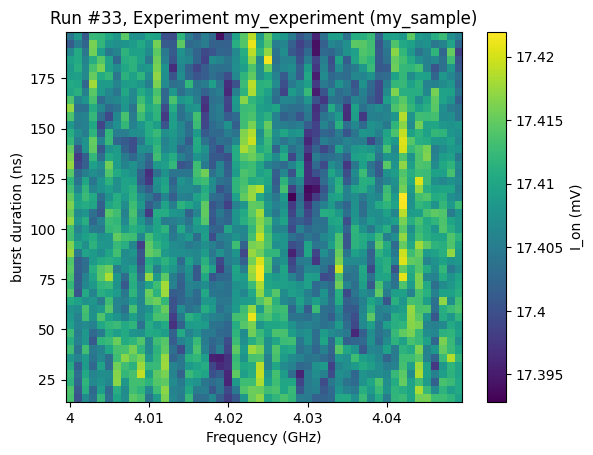

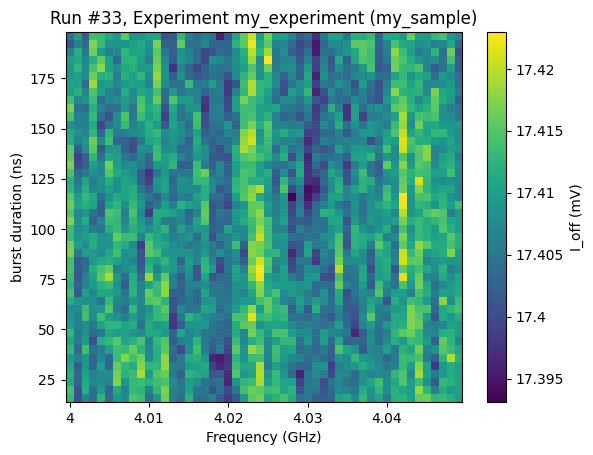

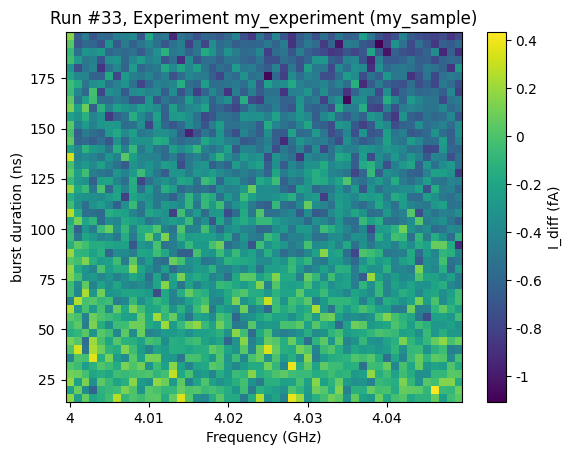

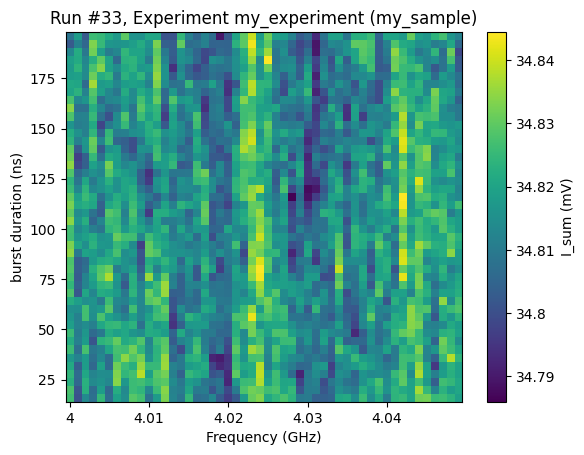

In [11]:
qubit_frequencies = np.arange(4.0 * u.GHz, 4.05 * u.GHz, 1 * u.MHz)
t_bursts = np.arange(16, 200, 4)
opx_instrument.set_sweep_parameters("axis1", t_bursts, "ns", "burst duration")  # axis2 is the most inner loop (not averaging)
opx_instrument.set_sweep_parameters("axis2", qubit_frequencies, "Hz", "Frequency")  # Axis2 is the second most inner loop (not averaging)
opx_instrument.qua_program = OPX_rabi_4ns(Coulomb_pk_to_pk = -0.7, 
                                        readout_duration = 10000,
                                        integration_time = 40000, 
                                        n_avg = 200, 
                                        IV_buffer_len = 160000, 
                                        drive_frequencies = qubit_frequencies, 
                                        burst_durations = t_bursts,
                                        simulate = False)
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    do_plot=True,
    exp=experiment,
)

The duration of the operation 'readout' from element 'TIA' is now 10000 ns
Rabi with a Coulomb pulse of -0.7 Vpp and a total integration time of 200 x 0ms = 0 s (readout_len = 10.0 µs)
Sweep the Rabi pulse frequency from 4.0 GHz to 4.049 GHz in steps of 1.000 MHz
Sweep the Rabi pulse duration from 16 ns to 196 ns in steps of 4.0 ns
Estimated runtime: 517.8 s
buffer size: 18.4 Msamples
Starting experimental run with id: 38. Using 'qcodes.dataset.do0d'
2023-10-17 17:46:07,866 - qm - INFO     - Sending program to QOP for compilation
2023-10-17 17:46:08,322 - qm - INFO     - Executing program
wait for I_on in 528.0262279510498 s
wait for I_off in 0.012259960174560547 s
wait for I_diff in 0.010987997055053711 s
wait for I_sum in 0.013004064559936523 s
get_res time: 528.1309385299683 s


(results #38@c:\git\qua-libs\Quantum-Control-Applications\Quantum-Dots\Nanowire\my_database.db
 ---------------------------------------------------------------------------------------------
 frequency - numeric
 burstduration - numeric
 I_on - numeric
 I_off - numeric
 I_diff - numeric
 I_sum - numeric,
 (<Axes: title={'center': 'Run #38, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>,
  <Axes: title={'center': 'Run #38, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>,
  <Axes: title={'center': 'Run #38, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>,
  <Axes: title={'center': 'Run #38, Experiment my_experiment (my_sample)'}, xlabel='Frequency (GHz)', ylabel='burst duration (ns)'>),
 (<matplotlib.colorbar.Colorbar at 0x1e41434ac50>,
  <matplotlib.colorbar.Colorbar at 0x1e41442b880>))

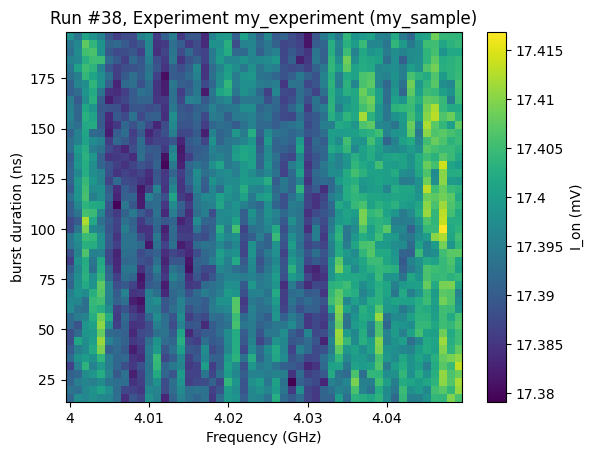

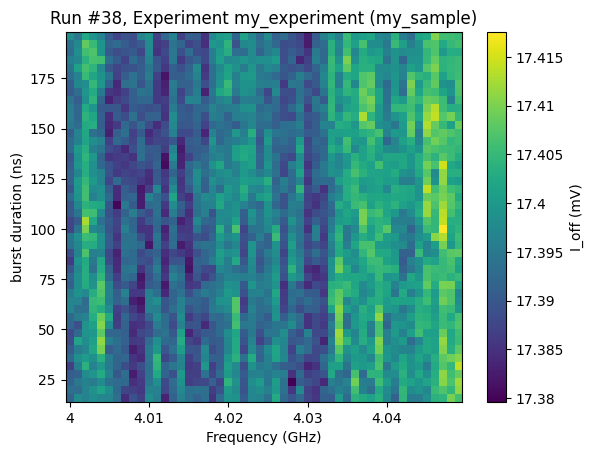

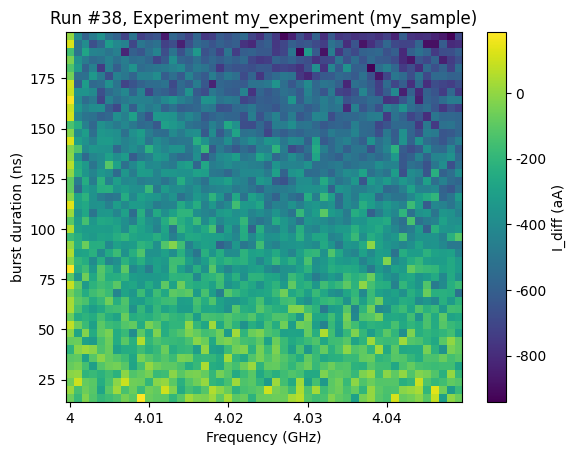

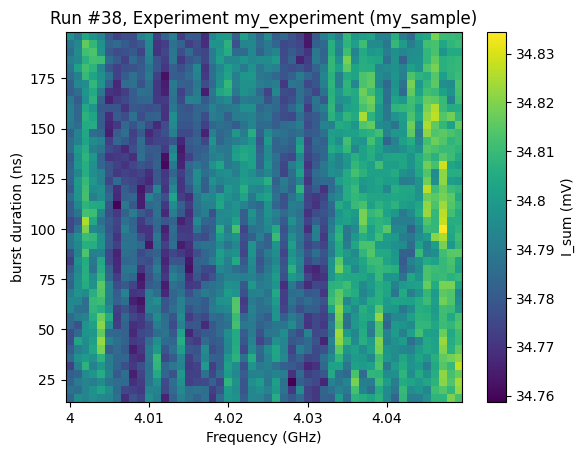

In [17]:
qubit_frequencies = np.arange(4.0 * u.GHz, 4.05 * u.GHz, 1 * u.MHz)
t_bursts = np.arange(16, 200, 4)
opx_instrument.set_sweep_parameters("axis1", t_bursts, "ns", "burst duration")  # axis2 is the most inner loop (not averaging)
opx_instrument.set_sweep_parameters("axis2", qubit_frequencies, "Hz", "Frequency")  # Axis2 is the second most inner loop (not averaging)
opx_instrument.qua_program = OPX_rabi_4ns(Coulomb_pk_to_pk = -0.7, 
                                        readout_duration = 10000,
                                        integration_time = 400000, 
                                        n_avg = 200, 
                                        IV_buffer_len = 160000, 
                                        drive_frequencies = qubit_frequencies, 
                                        burst_durations = t_bursts,
                                        simulate = False)
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    do_plot=True,
    exp=experiment,
)

In [ ]:
# Execute the sequence

# Set the Octave gain and LO for this experiment
# opx_instrument.qm.octave.set_rf_output_gain("qubit",10)
# opx_instrument.qm.octave.set_lo_frequency("qubit", 4.75e9)

# The qubit frequency sweep in Hz
qubit_frequencies = np.arange(4.0 * u.GHz, 4.05 * u.GHz, 10 * u.MHz)
opx_instrument.set_sweep_parameters("axis2", qubit_frequencies, "Hz", "Frequency")  # Axis2 is the second most inner loop (not averaging)
# The Rabi pulse duration sweep in ns - must be above 16ns with a step larger than 4ns
t_bursts = np.arange(16, 100, 4)
opx_instrument.set_sweep_parameters("axis1", t_bursts, "ns", "burst duration")  # axis2 is the most inner loop (not averaging)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_rabi_4ns(Coulomb_pk_to_pk = -0.7, 
                                        integration_time = 25*u.ms, 
                                        readout_duration = readout_len,
                                        n_avg = 1, 
                                        IV_buffer_len = 3 * u.ms, 
                                        drive_frequencies = qubit_frequencies, 
                                        burst_durations = t_bursts, 
                                        simulate = False)
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    do_plot=True,
    exp=experiment,
)

### Rabi chevron (frequency vs pulse duration) using real-time pulse streching (>16ns and 4ns granularity) with outer loop averaging, bitshifting and live plotting

In [ ]:
# Rabi with 4ns granularity QUA program with outer loop averaging and bit-shifting

def OPX_rabi_4ns(Coulomb_pk_to_pk:float = -0.7, readout_duration:int = readout_len, integration_time:int = 100*u.ms, n_avg:int = 10 , IV_buffer_len:int = 3_000_000, drive_frequencies:list = (), burst_durations:list = (), simulate:bool = True, live_plotting:bool = False):
    """
    QUA program for performing a Rabi chevron experiment with 4ns granularity. 
    A set of continuous Coulomb pulses is played with the qubit MW drive 'on' and 'off' successively, while the output of an IV converter is measured by the OPX.
    For averaging purposes, the sequence is repeated n_avg times for each qubit drive frequency.
    For current values are streamed: I_on, I_off, I_on-I_off and I_on+I_off.
    
    :param Coulomb_pk_to_pk: Peak to peak amplitude of the Coulomb pulse in V. Must smaller than 1V.
    :param readout_duration: Single readout pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param integration_time: Total integration time in ns. Will perform the readout for as many times as int(np.ceil(integration_time / readout_duration)) for when the qubit drive is 'on' and 'off'.
    :param n_avg: How many times the lock-in pattern ('on'-'off') is repeated at parameter sweep iteration for averaging.
    :param IV_buffer_len: Rise time of the IV converter in ns (for DC current sensing).
    :param drive_frequencies: Qubit drive frequency vector in Hz (IF+LO).
    :param burst_durations: Rabi pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param simulate: Flag to toggle between simulation and execution modes.
    :param live_plotting: Flag to enable live plotting with the OPX. Only works if no external parameters are being swept (do0d only).
    :return: The corresponding QUA program.
    """
    # Update readout_length
    update_readout_length(opx_instrument, "TIA", "readout", readout_duration)
    opx_instrument.readout_pulse_length(readout_duration)
    # Number of readout cycles - must be a multiple integer of 2 for efficient averaging on the FPGA with bit-shifting
    n_avg_ro = int(np.ceil(integration_time / readout_duration))
    n_avg_ro_pow2 = int(np.round(np.log2(n_avg_ro)))
    n_avg_ro = 2**n_avg_ro_pow2
    integration_time = n_avg_ro * readout_duration
    # Number of pulse cycles (+ 3µs to ensure that it will be longer than the total readout time)
    N = int((IV_buffer_len + integration_time + 3_000) / (2 * bias_length)) 
    # Convert the qubit frequency into IFs
    qubit_IFs = drive_frequencies - qubit_LO
    assert np.max(np.abs(qubit_IFs)) < 500e6, "The qubit IF must be lower than 500 MHz, you can either check that the specified frequency range is correct or adjust the LO"

    print(f"Rabi with a Coulomb pulse of {Coulomb_pk_to_pk} Vpp and a total integration time of {n_avg} x {integration_time / u.ms:.3f}ms = {n_avg*integration_time / u.ms:.3f} ms (readout_len = {readout_duration / u.us} µs)")
    print(f"Sweep the Rabi pulse frequency from {drive_frequencies[0] / u.GHz} GHz to {drive_frequencies[-1] / u.GHz} GHz in steps of {np.mean(np.diff(drive_frequencies)) / u.MHz:.3f} MHz")
    print(f"Sweep the Rabi pulse duration from {burst_durations[0]} ns to {burst_durations[-1]} ns in steps of {np.mean(np.diff(burst_durations))} ns")
    print(f"Estimated runtime: {n_avg * integration_time * len(burst_durations) * len(drive_frequencies) * 1e-9:.1f} s")
    
    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the outer averaging loop
        n_ro = declare(int)  # QUA integer used as an index for the inner averaging loop
        counter = declare(int)  # QUA integer used as an index for the Coulomb drive
        counter2 = declare(int)  # QUA integer used as an index for the Rabi drive
        f = declare(int)  # QUA integer for sweeping the qubit drive frequency
        t_burst = declare(int)  # QUA integer for sweeping the qubit pulse duration
        I_on = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        I_on_st = declare_stream()  # Stream for I_on
        I_off_st = declare_stream()  # Stream for I_off
        I_on_avg = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off_avg = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        n_st = declare_stream() # STream for n --> progress counter for live-plotting
        # Ensure that the result variables are assign to the pulse processor used for readout
        assign_variables_to_element("TIA", I_on, I_off)
        # Set the qubit drive frequency

        # The QUA sequence is embedded within an infinite loop in order to repeat it as many times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a "resume" command "which will be sent at each oteration of the external parameter sweep.
                pause()
           
            with for_(n , 0 , n < n_avg , n + 1):  # The outer averaging loop
                with for_(*from_array(f, qubit_IFs)):  # The outer averaging loop
                    update_frequency("qubit", f)
                    with for_(*from_array(t_burst, burst_durations // 4)):  # The outer averaging loop
                        assign(I_on_avg, 0)
                        assign(I_off_avg, 0)
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")  
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")

                        # Play the qubit sequence in a separated loop to avoid gaps in the Coulomb drive
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            wait(16 * u.ns, "qubit")  # Wait before driving the qubit
                            play("cw", "qubit", duration = t_burst)  # Rabi pulse
                            # Wait to always play at the same point of the Coulomb pulse
                            # Because the for_ loop and the real-time pulse streching takes some time, need to manually adjust the gap (19ns here)
                            # To precisely adjust the timing, please use the simulator
                            wait((2*bias_length)//4 - (t_burst + 17), "qubit")

                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_on
                            measure("readout", "TIA", None, integration.full("cos", I_on, "out1"))
                            assign(I_on_avg, I_on_avg + (I_on>>n_avg_ro_pow2))                             
                        save(I_on_avg, I_on_st)

                        align()    
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length without qubit drive
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")
                        
                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_off
                            measure("readout", "TIA", None, integration.full("cos", I_off, "out1"))
                            assign(I_off_avg, I_off_avg + (I_off>>n_avg_ro_pow2))
                        save(I_off_avg, I_off_st)
                save(n, n_st)
        
        with stream_processing():
            # Average and stream I_on, I_off, the difference and their sum
            if live_plotting:
                I_on_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_on")
                I_off_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_off")
                (I_on_st-I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_diff")
                (I_on_st+I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_sum")
                n_st.save("iteration")
            else:
                I_on_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_on")
                I_off_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_off")
                (I_on_st-I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_diff")
                (I_on_st+I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_sum")
        
    return prog

In [ ]:
# Execute the sequence
%matplotlib qt
# Set the Octave gain and LO for this experiment
# opx_instrument.qm.octave.set_rf_output_gain("qubit",10)
# opx_instrument.qm.octave.set_lo_frequency("qubit", 4.75e9)

n_avg = 10
# The qubit frequency sweep in Hz
qubit_frequencies = np.arange(4.0 * u.GHz, 4.05 * u.GHz, 1 * u.MHz)
opx_instrument.set_sweep_parameters("axis2", qubit_frequencies, "Hz", "Frequency")  # Axis2 is the second most inner loop (not averaging)
# The Rabi pulse duration sweep in ns - must be above 16ns with a step larger than 4ns
t_bursts = np.arange(16, 200, 4)
opx_instrument.set_sweep_parameters("axis1", t_bursts, "ns", "burst duration")  # axis2 is the most inner loop (not averaging)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_rabi_4ns(Coulomb_pk_to_pk = -0.7, 
                                        integration_time = 1*u.ms, 
                                        readout_duration = readout_len,
                                        n_avg = n_avg, 
                                        IV_buffer_len = 3 * u.ms, 
                                        drive_frequencies = qubit_frequencies, 
                                        burst_durations = t_bursts, 
                                        simulate = False,
                                        live_plotting=True)
# Compile the QUA program and execute it
opx_instrument.run_exp()
# Exit the pause() statement and start the sequence
opx_instrument.resume()
# Fetch the data in real-time and plot them
opx_instrument.live_plotting(["I_on", "I_off", "iteration"], n_avg)
# Update the data counter to save the last dataset to the qcodes database
opx_instrument.counter = n_avg
# Store the results in the qcodes database
do0d(
    opx_instrument.get_measurement_parameter(),
    do_plot=True,
    exp=experiment,
)

# do0d(
#     opx_instrument.run_exp,
#     opx_instrument.resume,
#     opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
#     opx_instrument.halt,
#     do_plot=True,
#     exp=experiment,
# )

### Rabi chevron (frequency vs pulse duration) using the baking tool (>0ns and 1ns granularity)

In [ ]:
# Rabi with baking QUA program
from qualang_tools.bakery import baking


def OPX_rabi_baking(Coulomb_pk_to_pk:float = -0.7, readout_duration:int = readout_len, integration_time:int = 100*u.ms, n_avg:int = 10 , IV_buffer_len:int = 3_000_000, drive_frequencies:list = (), burst_durations:list = (), simulate:bool = True, live_plotting:bool = False):
    """
    QUA program for performing a Rabi chevron experiment with 1ns granularity using the baking tool. 
    The 1ns granularity is achieved by pre-loading the (baked) waveforms to the OPX memory prior to starting the experiment (similarly to a standard AWG)
    A set of continuous Coulomb pulses is played with the qubit MW drive 'on' and 'off' successively, while the output of an IV converter is measured by the OPX.
    For averaging purposes, the sequence is repeated n_avg times for each qubit drive frequency.
    For current values are streamed: I_on, I_off, I_on-I_off and I_on+I_off.
    
    :param Coulomb_pk_to_pk: Peak to peak amplitude of the Coulomb pulse in V. Must smaller than 1V.
    :param readout_duration: Single readout pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param integration_time: Total integration time in ns. Will perform the readout for as many times as int(np.ceil(integration_time / readout_duration)) for when the qubit drive is 'on' and 'off'.
    :param n_avg: How many times the lock-in pattern ('on'-'off') is repeated at parameter sweep iteration for averaging.
    :param IV_buffer_len: Rise time of the IV converter in ns (for DC current sensing).
    :param drive_frequencies: Qubit drive frequency vector in Hz (IF+LO).
    :param burst_durations: Rabi pulse duration in ns. Must be a multiple of 4ns and larger than 16ns.
    :param simulate: Flag to toggle between simulation and execution modes.
    :param live_plotting: Flag to enable live plotting with the OPX. Only works if no external parameters are being swept (do0d only).
    :return: The corresponding QUA program.
    """
    
    # Number of readout cycles - must be a multiple integer of 2 for efficient averaging on the FPGA with bit-shifting
    n_avg_ro = int(np.ceil(integration_time / readout_duration))
    n_avg_ro_pow2 = int(np.round(np.log2(n_avg_ro)))
    n_avg_ro = 2**n_avg_ro_pow2
    integration_time = n_avg_ro * readout_duration
    # Number of pulse cycles (+ 3µs to ensure that it will be longer than the total readout time)
    N = int((IV_buffer_len + integration_time + 3_000) / (2 * bias_length)) 
    # Convert the qubit frequency into IFs
    qubit_IFs = drive_frequencies - qubit_LO
    assert np.max(np.abs(qubit_IFs)) < 500e6, "The qubit IF must be lower than 500 MHz, you can either check that the specified frequency range is correct or adjust the LO"

    # Bake the Rabi pulses
    pi_list = []
    for t in burst_durations:  # Create the different baked sequences
        t = int(t)
        with baking(opx_instrument.config, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
            if t == 0:
                wf_I = [0.0] * 16; wf_Q = [0.0] * 16  # Otherwise the baked pulse will be empty
            else:
                wf_I = [pi_amp] * t; wf_Q = [0.0] * t  # The baked waverforms (only the I quadrature)
            
            # Add the baked operation to the config
            b.add_op("pi_baked", "qubit", [wf_I, wf_Q])

            gap_to_adjust = 20  # gap to remove due to realtime calculations
            # Time to wait after playing the pulse in order to remain sync with the Coulomb pulse
            wait_time = (2 * bias_length) - (t + gap_to_adjust)
            # zero-pad the baked waveform to match the multiple-of-4ns requirement
            remainder = 4 - (t + wait_time) % 4

            # Baked sequence
            b.wait(16, "qubit")  # Wait before playing the qubit pulse (can be removed or adjusted)
            b.play("pi_baked", "qubit")  # Play the qubit pulse
            b.wait(wait_time + remainder, "qubit")  # Wait after the pulse in order to remain sync with the Coulomb pulse
                    
        # Append the baking object in the list to call it from the QUA program
        pi_list.append(b)

    # Update the config
    opx_instrument.set_config(config)
    opx_instrument.update_qm()

    print(f"Rabi with a Coulomb pulse of {Coulomb_pk_to_pk} Vpp and a total integration time of {n_avg} x {integration_time / u.ms:.0f}ms = {n_avg*integration_time / u.s:.0f} s (readout_len = {readout_len / u.us} µs)")
    print(f"Sweep the Rabi pulse frequency from {drive_frequencies[0] / u.GHz} GHz to {drive_frequencies[-1] / u.GHz} GHz in steps of {np.mean(np.diff(drive_frequencies)) / u.MHz:.3f} MHz")
    print(f"Sweep the Rabi pulse duration from {burst_durations[0]} ns to {burst_durations[-1]} ns in steps of {np.mean(np.diff(burst_durations))} ns")
    print(f"Estimated runtime: {n_avg * (IV_buffer_len + integration_time + 3_000) * len(burst_durations) * len(drive_frequencies) * 1e-9:.1f} s")
    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the outer averaging loop
        n_ro = declare(int)  # QUA integer used as an index for the inner averaging loop
        counter = declare(int)  # QUA integer used as an index for the Coulomb drive
        counter2 = declare(int)  # QUA integer used as an index for the Rabi drive
        f = declare(int)  # QUA integer for sweeping the qubit drive frequency
        baking_index = declare(int)  # QUA integer for sweeping the qubit pulse duration
        I_on = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        I_on_avg = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off_avg = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        I_on_st = declare_stream()  # Stream for I_on
        I_off_st = declare_stream()  # Stream for I_off
        n_st = declare_stream() # STream for n --> progress counter for live-plotting
        # Ensure that the result variables are assign to the pulse processor used for readout
        assign_variables_to_element("TIA", I_on, I_off)
        # Set the qubit drive frequency

        # The QUA sequence is embedded within an infinite loop in order to repeat it as many times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a "resume" command "which will be sent at each oteration of the external parameter sweep.
                pause()
           
            with for_(n , 0 , n < n_avg , n + 1):  # The outer averaging loop
                with for_(*from_array(f, qubit_IFs)):  # The outer averaging loop
                    update_frequency("qubit", f)
                    # with for_(*from_array(baking_index, np.arange(0, len(burst_durations), 1))):  # The outer averaging loop
                    with for_(baking_index, 0, baking_index < len(burst_durations), baking_index + 1):
                        assign(I_on_avg, 0)
                        assign(I_off_avg, 0)
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")  
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")

                        # Play the qubit sequence in a separated loop to avoid gaps in the Coulomb drive
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            # switch case to select the baked waveform corresponding to the burst duration
                            with switch_(baking_index, unsafe=True):
                                for ii in range(len(burst_durations)):
                                    with case_(ii):
                                        pi_list[ii].run()

                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_on
                            measure("readout", "TIA", None, integration.full("cos", I_on, "out1"))
                            assign(I_on_avg, I_on_avg + (I_on>>n_avg_ro_pow2))                             
                        save(I_on_avg, I_on_st)

                        align()    
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length without qubit drive
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")
                        
                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_off
                            measure("readout", "TIA", None, integration.full("cos", I_off, "out1"))
                            assign(I_off_avg, I_off_avg + (I_off>>n_avg_ro_pow2))                             
                        save(I_off_avg, I_off_st)
                save(n, n_st)
        
        with stream_processing():
            # Average and stream I_on, I_off, the difference and their sum
            if live_plotting:
                I_on_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_on")
                I_off_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_off")
                (I_on_st-I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_diff")
                (I_on_st+I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).average().save_all("I_sum")
                n_st.save("iteration")
            else:
                I_on_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_on")
                I_off_st.buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_off")
                (I_on_st-I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_diff")
                (I_on_st+I_off_st).buffer(len(burst_durations)).buffer(len(qubit_IFs)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I_sum")
        
    return prog

In [ ]:
# Simulate the QUA sequence

# The qubit frequency sweep in Hz
qubit_frequencies = np.arange(4.0 * u.GHz, 4.05 * u.GHz, 1 * u.MHz)
# The Rabi pulse duration sweep in ns
t_bursts = np.arange(1, 20, 1)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_rabi_baking(Coulomb_pk_to_pk = -0.7, 
                                        integration_time = 2*readout_len, 
                                        readout_duration = readout_len,
                                        n_avg = 1, 
                                        IV_buffer_len = 3 * u.us, 
                                        drive_frequencies = qubit_frequencies, 
                                        burst_durations = t_bursts, 
                                        simulate = True,
                                        live_plotting=False)

# Set for how long the sequence will be simulated in ns
opx_instrument.sim_time(10_000)
# Simulated the QUA program
opx_instrument.simulate()
# Plot the QUA program
opx_instrument.plot_simulated_wf()

In [ ]:
# Execute the sequence
%matplotlib qt
# Set the Octave gain and LO for this experiment
# opx_instrument.qm.octave.set_rf_output_gain("qubit",10)
# opx_instrument.qm.octave.set_lo_frequency("qubit", 4.75e9)

n_avg = 10
# The qubit frequency sweep in Hz
qubit_frequencies = np.arange(4.0 * u.GHz, 4.05 * u.GHz, 1 * u.MHz)
opx_instrument.set_sweep_parameters("axis2", qubit_frequencies, "Hz", "Frequency")  # Axis2 is the second most inner loop (not averaging)
# The Rabi pulse duration sweep in ns
t_bursts = np.arange(0, 100, 1)
opx_instrument.set_sweep_parameters("axis1", t_bursts, "ns", "burst duration")  # axis1 is the most inner loop (not averaging)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_rabi_baking(Coulomb_pk_to_pk = -0.7, 
                                        integration_time = 1*u.ms, 
                                        readout_duration = readout_len,
                                        n_avg = n_avg, 
                                        IV_buffer_len = 3 * u.ms, 
                                        drive_frequencies = qubit_frequencies, 
                                        burst_durations = t_bursts, 
                                        simulate = False,
                                        live_plotting=False)
# # Compile the QUA program and execute it
# opx_instrument.run_exp()
# # Exit the pause() statement and start the sequence
# opx_instrument.resume()
# # Fetch the data in real-time and plot them
# opx_instrument.live_plotting(["I_on", "I_off", "iteration"], n_avg)
# # Update the data counter to save the last dataset to the qcodes database
# opx_instrument.counter = n_avg
# # Store the results in the qcodes database
# do0d(
#     opx_instrument.get_measurement_parameter(),
#     do_plot=True,
#     exp=experiment,
# )

do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    do_plot=True,
    exp=experiment,
)

### Pi/2 duration calibration

In [ ]:
#####################################
#    Ramsey Pi half time calibration - Octave                  #  
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.

# Create the baked sequence
from qualang_tools.bakery import baking


# Stores the baking objects


def OPX_Pi_half_calibration_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, frequencies=(), pi_half_durations = (), ramsey_wait_time = 20, simulate = True):

    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+ 3_000)/(2*bias_length)) # number of pulse cycle
    pi_list = []
    
    
    for t in pi_half_durations:  # Create the different baked sequences
        t = int(t)
        with baking(opx_instrument.config, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
            if t == 0:
                wf_I_pi_half = [0.0] * 16; wf_Q_pi_half = [0.0] * 16  # Otherwise the baked pulse will be empty
            else:
                wf_I_pi_half = [IQ_amp] * t; wf_Q_pi_half = [0.0] * t
                
            
            wait_time = (2*bias_length)-2*t-4-ramsey_wait_time
            remainder = 4 - (2*t + wait_time) % 4
            
            b.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half])

            b.play("pi_half_baked", "qubit") 
            b.wait(ramsey_wait_time, "qubit")
            b.play("pi_half_baked", "qubit")
            
            b.wait(wait_time, "qubit")
            b.wait(remainder, "qubit")
                    
        # Append the baking object in the list to call it from the QUA program
        pi_list.append(b)
        
        
    opx_instrument.config = config
    opx_instrument.open_qm(close_other_machines = True)

    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        t_burst = declare(int)
        n = declare(int)
        i = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        counter2 = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
        
        with infinite_loop_():
            if not simulate:
                    pause()
            with for_(*from_array(i, np.arange(0,len(pi_half_durations)))):
                with for_(*from_array(f, frequencies)):
                    with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences

                        update_frequency("qubit", f)
                        assign(I_on, 0)
                        assign(I_off, 0)
                        with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            play("bias"*amp(-1*Campl), "gate_1")

                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(pi_half_durations)):
                                    with case_(ii):
                                        pi_list[ii].run()
                                        

                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I1, "out1"),
                            )
                            #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                            save(I1, I_on_st)
                        align()    
                        with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                            play("bias"*amp(-1*Campl), "gate_1")
                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I2, "out1"),
                            )
                            #assign(I_off, I_off + I2)


                            save(I2, I_off_st)
        
        with stream_processing():
            #I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_on")
            #I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(pi_half_durations)).save_all("I_diff")
            #(I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_sum")
        
    return prog

In [ ]:
import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)

# Rabi-Example
%matplotlib qt

qubit = ElementsSettings("qubit", gain=10)

IF_freq = np.arange(4.93e9,4.96e9,2e6)-qubit_LO
t_pi_halves = np.arange(1,30,1) # in ns
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis1", IF_freq + qubit_LO, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis2", t_pi_halves, "ns", "Pi/2 duration")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Pi_half_calibration_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 200, 
                                      frequencies=IF_freq,
                                      pi_half_durations = t_pi_halves,
                                    ramsey_wait_time = 20, 
                                      simulate = False)
# Simulate program

#opx_instrument.sim_time(10_000)
#opx_instrument.simulate()
#opx_instrument.plot_simulated_wf()
#plt.show()
# Execute program


do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    #opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)

Find a smart way to write the baked gates in the config and zero-pad outside

### Ramsey with baked gates and 4ns idle times

### Ramsey with baked gates and idle times

In [ ]:
# Rabi with baking QUA program
from qualang_tools.bakery import baking


def OPX_ramsey_full_baking(Coulomb_pk_to_pk:float = -0.7, integration_time:int = 100*u.ms, n_avg:int = 10 , IV_buffer_len:int = 3_000_000, drive_frequencies:list = (), idle_times:list = (), detuning:int = 0, simulate:bool = True):
    # Number of readout cycles
    n_avg_ro = int(np.ceil(integration_time / pulse_len))
    # Number of pulse cycles (+ 3µs to ensure that it will be longer than the total readout time)
    N = int((IV_buffer_len + integration_time + 3_000) / (2 * bias_length)) 
    # Convert the qubit frequency into IFs
    qubit_IFs = drive_frequencies - qubit_LO
    assert np.max(np.abs(qubit_IFs)) < 500e6, "The qubit IF must be lower than 500 MHz, you can either check that the specified frequency range is correct or adjust the LO"
    if len(qubit_IFs) == 1:
        frame_rotation = True
    else:
        frame_rotation = False

    # Bake the pi/2 pulses
    pi_list = []
    pi_reference_list = []
    for t in burst_durations:  # Create the different baked sequences
        t = int(t)
        # Bake the Ramsey sequence
        with baking(opx_instrument.config, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
            # generate the pi_half pulses
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration 
            # Add the baked operation to the config
            b.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half])

            # Different timings
            gap_to_adjust = 4  # gap to remove due to realtime calculations
            sequence_length = t + 2*pi_half_duration  # Duration of the baked sequence
            # Time to wait after playing the pulse in order to remain sync with the Coulomb pulse
            wait_time = (2 * bias_length) - (sequence_length + gap_to_adjust)
            # zero-pad the baked waveform to match the multiple-of-4ns requirement
            remainder = 4 - (sequence_length + wait_time) % 4
            
            # Baked sequence
            b.play("pi_half_baked", "qubit")  # 1st pi/2
            b.wait(t, "qubit")  # Ramsey idle time
            if frame_rotation:
                b.frame_rotation_2pi(detuning * t * 1e-9, "qubit")  # Rotate the 2nd pi/2 (virtual Z-rotation)
            b.play("pi_half_baked", "qubit")  # 2nd pi/2
            b.reset_frame("qubit")  # Reset the frame at the end of the sequence            
            b.wait(wait_time + remainder, "qubit")  # Wait after playing the sequence in order to remain sync with the Coulomb pulse
            
        # Bake the reference sequence (I_off) which corresponds to X/2 - idle - -X/2
        with baking(opx_instrument.config, padding_method="none") as b_ref:  # don't use padding to assure error if timing is incorrect
            # generate the pi_half pulses
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration
            wf_I_minus_pi_half = [-1*IQ_amp] * pi_half_duration; wf_Q_minus_pi_half  = [0.0] * pi_half_duration
            # Add the baked operations to the config
            b_ref.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half])
            b_ref.add_op("minus_pi_half_baked", "qubit", [wf_I_minus_pi_half, wf_Q_minus_pi_half])
            # Different timings
            gap_to_adjust = 4  # gap to remove due to realtime calculations
            sequence_length = t + 2*pi_half_duration  # Duration of the baked sequence
            # Time to wait after playing the pulse in order to remain sync with the Coulomb pulse
            wait_time = (2 * bias_length) - (sequence_length + gap_to_adjust)
            # zero-pad the baked waveform to match the multiple-of-4ns requirement
            remainder = 4 - (sequence_length + wait_time) % 4
                        
            # Baked sequence
            b.play("pi_half_baked", "qubit")  # 1st pi/2
            b.wait(t, "qubit")  # Ramsey idle time
            if frame_rotation:
                b.frame_rotation_2pi(detuning * t * 1e-9, "qubit")  # Rotate the 2nd pi/2 (virtual Z-rotation)
            b.play("minus_pi_half_baked", "qubit")  # 2nd pi/2 with minus sign
            b.reset_frame("qubit")  # Reset the frame at the end of the sequence            
            b.wait(wait_time + remainder, "qubit")  # Wait after playing the sequence in order to remain sync with the Coulomb pulse  
                    
        # Append the baking object in the list to call it from the QUA program
        pi_list.append(b)
        pi_reference_list.append(b_ref)

    # Update the config
    opx_instrument.config = config
    opx_instrument.open_qm(close_other_machines = True)

    print(f"Ramsey with a Coulomb pulse of {Coulomb_pk_to_pk} Vpp and a total integration time of {n_avg} x {integration_time / u.ms:.0f}ms = {n_avg*integration_time / u.s:.0f} s (readout_len = {readout_len / u.us} µs)")
    print(f"Sweep the qubit pulse frequency from {drive_frequencies[0] / u.GHz} GHz to {drive_frequencies[-1] / u.GHz} GHz in steps of {np.mean(np.diff(drive_frequencies)) / u.MHz:.3f} MHz")
    print(f"Sweep the Ramsey idle time from {idle_times[0]} ns to {idle_times[-1]} ns in steps of {np.mean(np.diff(idle_times))} ns")

    with program() as prog:
        n = declare(int)  # QUA integer used as an index for the outer averaging loop
        n_ro = declare(int)  # QUA integer used as an index for the inner averaging loop
        counter = declare(int)  # QUA integer used as an index for the Coulomb drive
        counter2 = declare(int)  # QUA integer used as an index for the Rabi drive
        f = declare(int)  # QUA integer for sweeping the qubit drive frequency
        baking_index = declare(int)  # QUA integer for looping over the baked waveforms
        I_on = declare(fixed)  # QUA fixed used to store the outcome of the readout when a qubit pulse is played
        I_off = declare(fixed)  # QUA fixed used to store the outcome of the readout without qubit pulse
        I_on_st = declare_stream()  # Stream for I_on
        I_off_st = declare_stream()  # Stream for I_off
        # Ensure that the result variables are assign to the pulse processor used for readout
        assign_variables_to_element("TIA", I_on, I_off)
        # Set the qubit drive frequency

        # The QUA sequence is embedded within an infinite loop in order to repeat it as many times as defined in the external parameter sweep (dond or else)
        with infinite_loop_():
            # Remove the "pause" statement when simulating the sequence
            if not simulate:
                # The sequence starts with a "pause statement that makes the pulse processor wait for a "resume" command "which will be sent at each oteration of the external parameter sweep.
                pause()
           
            with for_(n , 0 , n < n_avg , n + 1):  # The outer averaging loop
                with for_(*from_array(f, qubit_IFs)):  # The outer averaging loop
                    update_frequency("qubit", f)
                    with for_(*from_array(baking_index, np.arange(0, len(idle_times)))):  # The outer averaging loop
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")  
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")

                        # Play the qubit sequence in a separated loop to avoid gaps in the Coulomb drive
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            # switch case to select the baked waveform corresponding to the burst duration
                            with switch_(i, unsafe=True):
                                for ii in range(len(idle_times)):
                                    with case_(ii):
                                        pi_list[ii].run()

                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_on
                            measure("readout", "TIA", None, integration.full("cos", I_on, "out1"))
                            save(I_on, I_on_st)

                        align()    
                        # Play the Coulomb pulse continuously for a time given by coulomb_drive_length without qubit drive
                        with for_(counter, 0, counter < N, counter + 1):
                            # The Coulomb pulse
                            play("bias"*amp(Coulomb_pk_to_pk), "gate_1")
                            play("bias"*amp(-Coulomb_pk_to_pk), "gate_1")

                        # Play the reference sequence in a separated loop to avoid gaps in the Coulomb drive
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            # switch case to select the baked waveform corresponding to the burst duration
                            with switch_(i, unsafe=True):
                                for ii in range(len(idle_times)):
                                    with case_(ii):
                                        pi_reference_list[ii].run()
                                        
                        # Wait for the IV converter to reach its steady state and measure for a duration given by total_integration_time 
                        wait(IV_buffer_len * u.ns, "TIA")
                        with for_(n_ro, 0, n_ro < n_avg_ro, n_ro + 1):  # The inner averaging loop for I_off
                            measure("readout", "TIA", None, integration.full("cos", I_off, "out1"))
                            save(I_off, I_off_st)
        
        with stream_processing():
            # Average and stream I_on, I_off, the difference and their sum
            I_on_st.buffer(len(idle_times)).buffer(len(qubit_IFs)).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_on")
            I_off_st.buffer(len(idle_times)).buffer(len(qubit_IFs)).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_off")
            (I_on_st-I_off_st).buffer(len(idle_times)).buffer(len(qubit_IFs)).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_diff")
            (I_on_st+I_off_st).buffer(len(idle_times)).buffer(len(qubit_IFs)).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_sum")
        
    return prog

In [ ]:
# Simulate the QUA sequence

# The qubit frequency sweep in Hz
qubit_frequencies = [qubit_LO]
# The Rabi pulse duration sweep in ns
t_bursts = np.arange(1, 20, 1)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_ramsey_full_baking(Coulomb_pk_to_pk = -0.7, 
                                                    integration_time = 2*readout_len, 
                                                    n_avg = 1, 
                                                    IV_buffer_len = 3 * u.us, 
                                                    drive_frequencies = qubit_frequencies, 
                                                    idle_times = idle_times,
                                                    detuning = 300 * u.MHz,  # Only used if the drive frequency is constant (1D Ramsey)
                                                    simulate = True)

# Set for how long the sequence will be simulated in ns
opx_instrument.sim_time(10_000)
# Simulated the QUA program
opx_instrument.simulate()
# Plot the QUA program
opx_instrument.plot_simulated_wf()

In [ ]:
# Execute the sequence

# Set the Octave gain and LO for this experiment
# opx_instrument.qm.octave.set_rf_output_gain("qubit",10)
# opx_instrument.qm.octave.set_lo_frequency("qubit", 4.75e9)

# The qubit frequency sweep in Hz
qubit_frequencies = np.arange(4.94 * u.GHz, 5.0 * u.GHz, 1 * u.MHz)
opx_instrument.set_sweep_parameters("axis2", qubit_frequencies, "Hz", "Frequency")  # Axis2 is the second most inner loop (not averaging)
# The Rabi pulse duration sweep in ns
t_bursts = np.arange(0, 100, 1)
opx_instrument.set_sweep_parameters("axis1", idle_times, "ns", "Ramsey idle times")  # axis1 is the most inner loop (not averaging)

# Specify the readout length used in this experiment to convert the results into Volts and 
# define the setpoints for the time axis when acquiring the raw adc traces or using the sliced/accumulated integration/demodulation.
# Note that this doesn't set the readout length, it would need to be done in the configuration.
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_ramsey_full_baking(Coulomb_pk_to_pk = -0.7, 
                                                    integration_time = 100*u.ms, 
                                                    n_avg = 500, 
                                                    IV_buffer_len = 3 * u.ms, 
                                                    drive_frequencies = qubit_frequencies, 
                                                    idle_times = idle_times,
                                                    detuning = 300 * u.MHz,  # Only used if the drive frequency is constant (1D Ramsey)
                                                    simulate = False)
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    do_plot=True,
    exp=experiment,
)

In [ ]:
#####################################
#    Ramsey baked - Octave                #  
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.

# Create the baked sequence
from qualang_tools.bakery import baking





# Stores the baking objects




def OPX_Ramsey_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, frequencies=(), pi_half_duration = None, ramsey_wait_times= (), simulate = True):

    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+ 3_000)/(2*bias_length)) # number of pulse cycle
    pi_list = []
    pi_reference_list = []
    
    if pi_half_duration is None:
        raise ValueError("Pleas define a finite pi_half duration!")
    
    for t in ramsey_wait_times:  # Create the different baked sequences
        t = int(t)
        # need to verify (assert?) that the baked waveform:
        # 1. form a multiple of 4 ns. Here, by construction it's 4*t + 2 * pi_len = 4(t + pi_len/2),
        #    so it's enough to require that pi_len is even
        # 2. the entire waveform is >= 16 ns (4 cycles). Here t >= 1 so 2*pi_len >= 12 is required,
        # HOWEVER, due to a different limitation, pi_len >= 16 is currently  required (will work to fix that)
        with baking(opx_instrument.config, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
            
          
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration # generate the pi_half pulses
                
            
            wait_time = (2*bias_length)-t-2*pi_half_duration - 4       # calculating the waiting time between two ramsey sequences
            remainder = 4 - (2*pi_half_duration + t+ wait_time) % 4 # zero-pad to match waveform length to be n*4 ns
            
            b.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half]) # add the waveform for the pi_half pulse
            
            # assembling the sequence
            
            b.play("pi_half_baked", "qubit") 
            b.wait(t, "qubit")
            b.play("pi_half_baked", "qubit")
            
            b.wait(wait_time, "qubit")
            b.wait(remainder, "qubit")
            
        with baking(opx_instrument.config, padding_method="none") as b_ref:  # don't use padding to assure error if timing is incorrect
            
          
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration # generate the pi_half pulses
            wf_I_pi_half_reversed = [-1*IQ_amp] * pi_half_duration; wf_Q_pi_half_reversed  = [0.0] * pi_half_duration # generate the pi_half pulses
                
            
            wait_time = (2*bias_length)-t-2*pi_half_duration - 4       # calculating the waiting time between two ramsey sequences
            remainder = 4 - (2*pi_half_duration + t+ wait_time) % 4 # zero-pad to match waveform length to be n*4 ns
            
            b_ref.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half]) # add the waveform for the pi_half pulse
            b_ref.add_op("pi_half_baked_reverse", "qubit", [wf_I_pi_half_reversed, wf_Q_pi_half_reversed]) # add the waveform for the pi_half pulse
            # assembling the sequence
            
            b_ref.play("pi_half_baked", "qubit") 
            b_ref.wait(t, "qubit")
            b_ref.play("pi_half_baked_reverse", "qubit")
            
            b_ref.wait(wait_time, "qubit")
            b_ref.wait(remainder, "qubit")    
                    
        # Append the baking object in the list to call it from the QUA program
        pi_list.append(b)
        pi_reference_list.append(b_ref)
        
        
    opx_instrument.config = config
    opx_instrument.open_qm(close_other_machines = True)

    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        t_burst = declare(int)
        n = declare(int)
        i = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        counter2 = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
        
        with infinite_loop_():
            if not simulate:
                    pause()
            
            with for_(*from_array(i, np.arange(0,len(ramsey_wait_times)))):
                with for_(*from_array(f, frequencies)):
                    with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences
                        if simulate:
                            update_frequency("qubit", 0)#f)
                        else:
                            update_frequency("qubit", f)
                        assign(I_on, 0)
                        assign(I_off, 0)
                        with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            play("bias"*amp(-1*Campl), "gate_1")

                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(ramsey_wait_times)):
                                    with case_(ii):
                                        pi_list[ii].run()
                                        

                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I1, "out1"),
                            )
                            #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                            save(I1, I_on_st)
                        align()    
                        with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                            play("bias"*amp(-1*Campl), "gate_1")
                        
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(ramsey_wait_times)):
                                    with case_(ii):
                                        pi_reference_list[ii].run()
                                        
                                        
                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I2, "out1"),
                            )
                            #assign(I_off, I_off + I2)


                            save(I2, I_off_st)
        
        with stream_processing():
            #I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_on")
            #I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(ramsey_wait_times)).save_all("I_diff")
            #(I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_sum")
        
    return prog

In [ ]:
import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)

# Rabi-Example
%matplotlib qt

qubit = ElementsSettings("qubit", gain=10)

IF_freq = np.arange(4.93e9,4.96e9,3e6)-qubit_LO
t_wait = np.arange(1,120,6) # in ns
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis1", IF_freq + qubit_LO, "Hz", "Frequency")
opx_instrument.set_sweep_parameters("axis2", t_wait, "ns", "Ramsey waiting time")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Ramsey_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 500, 
                                      frequencies=IF_freq,
                                      pi_half_duration = 15,
                                    ramsey_wait_times = t_wait, 
                                      simulate = False)
# Simulate program
"""
opx_instrument.sim_time(10_000)
opx_instrument.simulate()
opx_instrument.plot_simulated_wf()
plt.show()
# Execute program

"""
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    #opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)

In [ ]:
#####################################
#    Ramsey baked artificial phase on second pi_half pulse - Octave                #  
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.

# Create the baked sequence
from qualang_tools.bakery import baking





# Stores the baking objects




def OPX_Ramsey_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, frequencies=(), pi_half_duration = None, ramsey_wait_times= (), artificial_oscillation_frequency = 0, simulate = True):

    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+ 3_000)/(2*bias_length)) # number of pulse cycle
    pi_list = []
    pi_reference_list = []
    
    if pi_half_duration is None:
        raise ValueError("Pleas define a finite pi_half duration!")
    
    for t in ramsey_wait_times:  # Create the different baked sequences
        t = int(t)
        # need to verify (assert?) that the baked waveform:
        # 1. form a multiple of 4 ns. Here, by construction it's 4*t + 2 * pi_len = 4(t + pi_len/2),
        #    so it's enough to require that pi_len is even
        # 2. the entire waveform is >= 16 ns (4 cycles). Here t >= 1 so 2*pi_len >= 12 is required,
        # HOWEVER, due to a different limitation, pi_len >= 16 is currently  required (will work to fix that)
        with baking(opx_instrument.config, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
            
          
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration # generate the pi_half pulses
                
            
            wait_time = (2*bias_length)-t-2*pi_half_duration - 4       # calculating the waiting time between two ramsey sequences
            remainder = 4 - (2*pi_half_duration + t+ wait_time) % 4 # zero-pad to match waveform length to be n*4 ns
            
            b.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half]) # add the waveform for the pi_half pulse
            
            # assembling the sequence
            
            b.play("pi_half_baked", "qubit") 
            b.wait(t, "qubit")
            b.frame_rotation_2pi(artificial_oscillation_frequency*t*1e-9,"qubit")
            b.play("pi_half_baked", "qubit")
            b.reset_frame("qubit")
            
            b.wait(wait_time, "qubit")
            b.wait(remainder, "qubit")
            
        with baking(opx_instrument.config, padding_method="none") as b_ref:  # don't use padding to assure error if timing is incorrect
            
          
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration # generate the pi_half pulses
            wf_I_pi_half_reversed = [-1*IQ_amp] * pi_half_duration; wf_Q_pi_half_reversed  = [0.0] * pi_half_duration # generate the pi_half pulses
                
            
            wait_time = (2*bias_length)-t-2*pi_half_duration - 4       # calculating the waiting time between two ramsey sequences
            remainder = 4 - (2*pi_half_duration + t+ wait_time) % 4 # zero-pad to match waveform length to be n*4 ns
            
            b_ref.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half]) # add the waveform for the pi_half pulse
            b_ref.add_op("pi_half_baked_reverse", "qubit", [wf_I_pi_half_reversed, wf_Q_pi_half_reversed]) # add the waveform for the pi_half pulse
            # assembling the sequence
            
            b_ref.play("pi_half_baked", "qubit") 
            b_ref.wait(t, "qubit")
            b_ref.frame_rotation_2pi(artificial_oscillation_frequency*t*1e-9,"qubit")
            b_ref.play("pi_half_baked_reverse", "qubit")
            b_ref.reset_frame("qubit")
            
            b_ref.wait(wait_time, "qubit")
            b_ref.wait(remainder, "qubit")    
                    
        # Append the baking object in the list to call it from the QUA program
        pi_list.append(b)
        pi_reference_list.append(b_ref)
        
        
    opx_instrument.config = config
    opx_instrument.open_qm(close_other_machines = True)

    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        t_burst = declare(int)
        n = declare(int)
        i = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        counter2 = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
        
        with infinite_loop_():
            if not simulate:
                    pause()
            
            with for_(*from_array(i, np.arange(0,len(ramsey_wait_times)))):
                with for_(*from_array(f, frequencies)):
                    with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences
                        if simulate:
                            update_frequency("qubit", 0)#f)
                        else:
                            update_frequency("qubit", f)
                        assign(I_on, 0)
                        assign(I_off, 0)
                        with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            play("bias"*amp(-1*Campl), "gate_1")

                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(ramsey_wait_times)):
                                    with case_(ii):
                                        pi_list[ii].run()
                                        

                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I1, "out1"),
                            )
                            #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                            save(I1, I_on_st)
                        align()    
                        with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                            play("bias"*amp(-1*Campl), "gate_1")
                        
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(ramsey_wait_times)):
                                    with case_(ii):
                                        pi_reference_list[ii].run()
                                        
                                        
                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I2, "out1"),
                            )
                            #assign(I_off, I_off + I2)


                            save(I2, I_off_st)
        
        with stream_processing():
            #I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_on")
            #I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(ramsey_wait_times)).save_all("I_diff")
            #(I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_sum")
        
    return prog

In [ ]:
import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)

# Rabi-Example
%matplotlib qt

qubit = ElementsSettings("qubit", gain=10)

IF_freq = np.array([4.94328e9])-qubit_LO
t_wait = np.arange(0,120,2) # in ns
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
#opx_instrument.set_sweep_parameters("axis1", IF_freq + qubit_LO, "Hz", "Frequency")
opx_instrument.set_sweep_parameters("axis2", t_wait, "ns", "Ramsey waiting time")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Ramsey_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 500, 
                                      frequencies=IF_freq,
                                      pi_half_duration = 15,
                                    ramsey_wait_times = t_wait, 
                                        artificial_oscillation_frequency = 30e6,
                                      simulate = False)
# Simulate program
"""
opx_instrument.sim_time(10_000)
opx_instrument.simulate()
opx_instrument.plot_simulated_wf()
plt.show()
# Execute program

"""
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    #opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)

In [ ]:
#####################################
#   Campl Scan with compensation                #  
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.



def OPX_Campl_scan(n_avg_ro_in = 10, n_avg_in = 10 , IV_buffer_len_in = 3_000_000, simulate = True):

    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+ 3_000)/(2*bias_length)) # number of pulse cycle
    
    
    opx_instrument.config = config
    opx_instrument.open_qm(close_other_machines = True)

    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        t_burst = declare(int)
        n = declare(int)
        i = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        Campl_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        Campl = declare(fixed)
        
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
        
        with infinite_loop_():
            if not simulate:
                pause()
                assign(Campl, IO1)
                save(Campl, Campl_st)
            
            with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences
                assign(I_on, 0)
                assign(I_off, 0)
                with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                    play("bias"*amp(1*Campl), "gate_1")
                    play("cw", "qubit")
                    play("bias"*amp(-1*Campl), "gate_1")


                wait(IV_buffer_len//4, "TIA")
                with for_(ro, 0, ro < n_avg_ro, ro + 1):
                    measure(
                        "readout",
                        "TIA",
                        None,
                        integration.full("cos", I1, "out1"),
                    )
                    #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                    save(I1, I_on_st)
                align()    
                with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                    play("bias"*amp(1*Campl), "gate_1")
                    #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                    play("bias"*amp(-1*Campl), "gate_1")



                wait(IV_buffer_len//4, "TIA")
                with for_(ro, 0, ro < n_avg_ro, ro + 1):
                    measure(
                        "readout",
                        "TIA",
                        None,
                        integration.full("cos", I2, "out1"),
                    )
                    #assign(I_off, I_off + I2)


                    save(I2, I_off_st)
        
        with stream_processing():
            #I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_on")
            #I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_diff")
            (I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_sum")
            Campl_st.save_all("Campl_qua")
        
    return prog

In [ ]:
import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)

# Rabi-Example
%matplotlib qt

qubit = ElementsSettings("qubit", gain=10)


VP2(-2.45)
VP1(-4)



opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Campl_scan(n_avg_ro_in = 10, n_avg_in = 50, 
                                      simulate = False)
# Simulate program
"""
opx_instrument.sim_time(10_000)
opx_instrument.simulate()
opx_instrument.plot_simulated_wf()
plt.show()
# Execute program

"""
do2d(Campl,0,-1,10,1,VP1,-3.95,-3.6,20,0.1,
    Campl.update,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    #opx_instrument.get_measurement_parameter(), 
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    #do_plot=True,
    exp=experiment,
)

In [ ]:
VP2()

# Best Code examples:

In [ ]:
import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)

In [ ]:
# Configure the Octave parameters for each element
# resonator = ElementsSettings("resonator", gain=0, rf_in_port=["octave1", 1], down_convert_LO_source="Internal")
qubit = ElementsSettings("qubit", gain=10)
# Add the "octave" elements
elements_settings = [qubit]

###################
# Octave settings #
###################
# Configure the Octave according to the elements settings and calibrate

from qm.QuantumMachinesManager import QuantumMachinesManager
# qmm = QuantumMachinesManager(host=qop_ip, cluster_name = "New_VTI", octave=octave_config, log_level="ERROR")
octave_settings(
    opx_instrument,
    config=config,
    octaves=octaves,
    elements_settings=elements_settings,
    calibration=True,
)

In [ ]:
# Fetch data from OPX after wrong assignment of axes

opx_instrument.set_sweep_parameters("axis1", IF_freq + qubit_LO, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis2", t_pi_halves, "ns", "Pi_half duration")
do0d(
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    exp=experiment,
)

## CW pulsing, no sweep on OPX

### OPX Program

In [ ]:
# CW EDSR pulsing i.e. for readout-search


def OPX_pulsed_EDSR_CW(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, drive_frequency=(), simulate = True):
    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+3_000)/(2*bias_length)) # number of pulse cycles
    
    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int, value = int(drive_frequency - qubit_LO))
        n = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
    
        with infinite_loop_():
            if not simulate:
                    pause()
           
            with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences

                update_frequency("qubit", f)
                assign(I_on, 0)
                assign(I_off, 0)
                with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                    play("bias"*amp(1*Campl), "gate_1")
                    #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                    #with if_(flag):
                    play("cw", "qubit")
                    play("bias"*amp(-1*Campl), "gate_1")
                    #wait((200-22) // 4 , "gate_1")
                wait(IV_buffer_len//4, "TIA")
                with for_(ro, 0, ro < n_avg_ro, ro + 1):
                    measure(
                        "readout",
                        "TIA",
                        None,
                        integration.full("cos", I1, "out1"),
                    )
                    #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                    save(I1, I_on_st)
                align()    
                with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                    play("bias"*amp(1*Campl), "gate_1")
                    #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                    play("bias"*amp(-1*Campl), "gate_1")
                wait(IV_buffer_len//4, "TIA")
                with for_(ro, 0, ro < n_avg_ro, ro + 1):
                    measure(
                        "readout",
                        "TIA",
                        None,
                        integration.full("cos", I2, "out1"),
                    )
                    #assign(I_off, I_off + I2)
                    save(I2, I_off_st)
        
        with stream_processing():
            I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_on")
            I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_diff")
            (I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).save_all("I_sum")
        
    return prog

### Pulsed Triangle-scan

In [ ]:
opx_instrument.qm.octave.set_rf_output_gain("qubit",10)

opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_pulsed_EDSR_CW(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 500, drive_frequency=4.948e9, simulate = False)

do2d(VP1,-3.9,-4.1,30,2,VP2,-2.43,-2.54,30,1,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    #opx_instrument.get_measurement_parameter(), 
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    #do_plot=True,
    exp=experiment,
)

### Pused B-scan looking for resonance

In [ ]:


opx_instrument.qm.octave.set_rf_output_gain("qubit",10)

import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)


ips.field_setpoint(0.18)
sleep(10)

opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_pulsed_EDSR_CW(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 250, drive_frequency=4.948e9, simulate = False)
# Simulate program

do1d(ips.field_setpoint,0.18,0.13,300,2,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    #opx_instrument.get_measurement_parameter(), 
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    #do_plot=True,
    exp=experiment,
)

## Pulsed EDSR, sweeping frequency on OPX

### OPX Program

In [ ]:
#####################################
#    EDSR - Octave      #   All avgs in stream processing
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.

def OPX_pulsed_EDSR(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, frequencies=(), simulate = True):
    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+3_000)/(2*bias_length)) # number of pulse cycles
    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        n = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
    
        with infinite_loop_():
            if not simulate:
                    pause()
            with for_(*from_array(f, frequencies)):
                with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences
                
                    update_frequency("qubit", f)
                    assign(I_on, 0)
                    assign(I_off, 0)
                    with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                        play("bias"*amp(1*Campl), "gate_1")
                        #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                        #with if_(flag):
                        play("cw", "qubit")
                        play("bias"*amp(-1*Campl), "gate_1")
                        #wait((200-22) // 4 , "gate_1")
                    wait(IV_buffer_len//4, "TIA")
                    with for_(ro, 0, ro < n_avg_ro, ro + 1):
                        measure(
                            "readout",
                            "TIA",
                            None,
                            integration.full("cos", I1, "out1"),
                        )
                        #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                        save(I1, I_on_st)
                    align()    
                    with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                        play("bias"*amp(1*Campl), "gate_1")
                        #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                        play("bias"*amp(-1*Campl), "gate_1")
                    wait(IV_buffer_len//4, "TIA")
                    with for_(ro, 0, ro < n_avg_ro, ro + 1):
                        measure(
                            "readout",
                            "TIA",
                            None,
                            integration.full("cos", I2, "out1"),
                        )
                        #assign(I_off, I_off + I2)

                        
                        save(I2, I_off_st)
        
        with stream_processing():
            I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).save_all("I_on")
            I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).save_all("I_diff")
            (I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).save_all("I_sum")
        
    return prog

### EDSR scan B vs frequency

In [ ]:
# EDSR example (B vs freq scan)

IF_freq = np.arange(-100e6,250e6,3.1e6)
VP2(-2.45)
VP1(-4)

ips.field_setpoint(0.13)


#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis1", IF_freq +qubit_LO, "Hz", "frequency")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_pulsed_EDSR(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 1000, frequencies=IF_freq, simulate = False)
# Simulate program

do1d(ips.field_setpoint,0.13,0.18,20,2,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    #opx_instrument.get_measurement_parameter(), 
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    #do_plot=True,
    exp=experiment,
)

### EDSR 1D scan

In [ ]:
# EDSR-Example (1D scan)

IF_freq = np.arange(4.91e9,4.98e9,1e6)-qubit_LO
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis1", IF_freq +qubit_LO, "Hz", "frequency")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_pulsed_EDSR(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 1000, frequencies=IF_freq, simulate = False)
# Simulate program

do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)

## Rabi

In [ ]:
#####################################
#    Rabi - Octave                  #  
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.

def OPX_Rabi(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, frequencies=(), burst_durations = (),  simulate = True):
    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    burst_durations_clockcycles = burst_durations//4
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+3_000)/(2*bias_length)) # number of pulse cycles
    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        t_burst = declare(int)
        n = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        counter2 = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
    
        with infinite_loop_():
            if not simulate:
                    pause()
            with for_(*from_array(t_burst, burst_durations_clockcycles)):
                with for_(*from_array(f, frequencies)):
                    with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences

                        update_frequency("qubit", f)
                        assign(I_on, 0)
                        assign(I_off, 0)
                        wait(4, "gate_1")
                        with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                            
                            play("bias"*amp(1*Campl), "gate_1")
                            play("bias"*amp(-1*Campl), "gate_1")
                            #wait((200-22) // 4 , "gate_1")
                        with for_(counter2, 0, counter2 < N, counter2 + 1):   # playing coulomb & IQ-pulse
                            play("cw", "qubit", duration = t_burst)
                            wait((2*bias_length)//4-t_burst-19,"qubit")
                            
                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I1, "out1"),
                            )
                            #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                            save(I1, I_on_st)
                        align()    
                        with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                            play("bias"*amp(-1*Campl), "gate_1")
                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I2, "out1"),
                            )
                            #assign(I_off, I_off + I2)


                            save(I2, I_off_st)
        
        with stream_processing():
            #I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_on")
            #I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_diff")
            #(I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_sum")
        
    return prog

In [ ]:
# Rabi-Example

IF_freq = np.arange(4.9e9,4.98e9,6e6)-qubit_LO
t_bursts = np.arange(16,90,8) # in ns
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis1", IF_freq +qubit_LO, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis2", t_bursts, "ns", "burst duration")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Rabi(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 500, 
                                      frequencies=IF_freq,
                                      burst_durations = t_bursts, 
                                      simulate = False)
# Simulate program

do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    #opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)

In [ ]:
#####################################
#    Rabi with baking - Octave                  #  
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.

# Create the baked sequence
from qualang_tools.bakery import baking





# Stores the baking objects




def OPX_Rabi_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, frequencies=(), burst_durations = (), simulate = True):

    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+ 3_000)/(2*bias_length)) # number of pulse cycle
    pi_list = []
    for t in burst_durations:  # Create the different baked sequences
        t = int(t)
        # need to verify (assert?) that the baked waveform:
        # 1. form a multiple of 4 ns. Here, by construction it's 4*t + 2 * pi_len = 4(t + pi_len/2),
        #    so it's enough to require that pi_len is even
        # 2. the entire waveform is >= 16 ns (4 cycles). Here t >= 1 so 2*pi_len >= 12 is required,
        # HOWEVER, due to a different limitation, pi_len >= 16 is currently  required (will work to fix that)
        with baking(opx_instrument.config, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
            if t == 0:
                wf_I = [0.0] * 16; wf_Q = [0.0] * 16  # Otherwise the baked pulse will be empty
            else:
                wf_I = [pi_amp] * t; wf_Q = [0.0] * t
                
            wait_time = (2*bias_length)-t-4
            remainder = 4 - (t + wait_time) % 4
            b.add_op("pi_baked", "qubit", [wf_I, wf_Q])

            b.play("pi_baked", "qubit") 
            b.wait(wait_time, "qubit")
            
            b.wait(remainder, "qubit")
                    
        # Append the baking object in the list to call it from the QUA program
        pi_list.append(b)
    opx_instrument.config = config
    opx_instrument.open_qm(close_other_machines = True)

    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        t_burst = declare(int)
        n = declare(int)
        i = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        counter2 = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
        
        with infinite_loop_():
            if not simulate:
                    pause()
            with for_(*from_array(i, np.arange(0,len(burst_durations)))):
                with for_(*from_array(f, frequencies)):
                    with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences

                        update_frequency("qubit", f)
                        assign(I_on, 0)
                        assign(I_off, 0)
                        with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            play("bias"*amp(-1*Campl), "gate_1")

                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(burst_durations)):
                                    with case_(ii):
                                        pi_list[ii].run()
                                        

                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I1, "out1"),
                            )
                            #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                            save(I1, I_on_st)
                        align()    
                        with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                            play("bias"*amp(-1*Campl), "gate_1")
                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I2, "out1"),
                            )
                            #assign(I_off, I_off + I2)


                            save(I2, I_off_st)
        
        with stream_processing():
            #I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_on")
            #I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_diff")
            #(I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_sum")
        
    return prog

In [ ]:
# Rabi-Example
%matplotlib qt

IF_freq = np.arange(4.9e9,4.98e9,6e6)-qubit_LO
t_bursts = np.arange(1,82,5) # in ns
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis1", IF_freq +qubit_LO, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis2", t_bursts, "ns", "burst duration")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Rabi_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 1000, 
                                      frequencies=IF_freq,
                                      burst_durations = t_bursts, 
                                      simulate = False)
# Simulate program

#opx_instrument.sim_time(10_000)
#opx_instrument.simulate()
#opx_instrument.plot_simulated_wf()
#plt.show()
# Execute program

do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    #opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)

## Ramsey

In [ ]:
# Ramsey pi/2 calibration

import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)


%matplotlib qt

qubit = ElementsSettings("qubit", gain=10)

IF_freq = np.arange(4.93e9,4.96e9,2e6)-qubit_LO
t_pi_halves = np.arange(1,30,1) # in ns
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis1", IF_freq + qubit_LO, "Hz", "frequency")
opx_instrument.set_sweep_parameters("axis2", t_pi_halves, "ns", "Pi/2 duration")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Pi_half_calibration_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 200, 
                                      frequencies=IF_freq,
                                      pi_half_durations = t_pi_halves,
                                    ramsey_wait_time = 20, 
                                      simulate = False)
# Simulate program

#opx_instrument.sim_time(10_000)
#opx_instrument.simulate()
#opx_instrument.plot_simulated_wf()
#plt.show()
# Execute program


do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    #opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)

In [ ]:
#####################################
#    Ramsey baked artificial phase on second pi_half pulse - Octave                #  
#####################################
# Demonstrate how to perform a single point measurement with the OPX
# by integrating the readout signals while performing an external 2D sweep
# with the do2d function.

# Create the baked sequence
from qualang_tools.bakery import baking





# Stores the baking objects




def OPX_Ramsey_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 10 , IV_buffer_len_in = 3_000_000, frequencies=(), pi_half_duration = None, ramsey_wait_times= (), artificial_oscillation_frequency = 0, simulate = True):

    IV_buffer_len = IV_buffer_len_in # in ns to give IV converter enough time to stabilize 
    
    Campl = Campl_in
    n_avg_ro = n_avg_ro_in # Bit-shifted, therefore 2**n_avg_ro is actual averaging time!!!
    n_avg = n_avg_in  # 10 is equivalent to approx 400 ms pulses -> 100 ms measurement time 
    N = int((IV_buffer_len + readout_len*(n_avg_ro)+ 3_000)/(2*bias_length)) # number of pulse cycle
    pi_list = []
    pi_reference_list = []
    
    if pi_half_duration is None:
        raise ValueError("Pleas define a finite pi_half duration!")
    
    for t in ramsey_wait_times:  # Create the different baked sequences
        t = int(t)
        # need to verify (assert?) that the baked waveform:
        # 1. form a multiple of 4 ns. Here, by construction it's 4*t + 2 * pi_len = 4(t + pi_len/2),
        #    so it's enough to require that pi_len is even
        # 2. the entire waveform is >= 16 ns (4 cycles). Here t >= 1 so 2*pi_len >= 12 is required,
        # HOWEVER, due to a different limitation, pi_len >= 16 is currently  required (will work to fix that)
        with baking(opx_instrument.config, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
            
          
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration # generate the pi_half pulses
                
            
            wait_time = (2*bias_length)-t-2*pi_half_duration - 4       # calculating the waiting time between two ramsey sequences
            remainder = 4 - (2*pi_half_duration + t+ wait_time) % 4 # zero-pad to match waveform length to be n*4 ns
            
            b.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half]) # add the waveform for the pi_half pulse
            
            # assembling the sequence
            
            b.play("pi_half_baked", "qubit") 
            b.wait(t, "qubit")
            b.frame_rotation_2pi(artificial_oscillation_frequency*t*1e-9,"qubit")
            b.play("pi_half_baked", "qubit")
            b.reset_frame("qubit")
            
            b.wait(wait_time, "qubit")
            b.wait(remainder, "qubit")
            
        with baking(opx_instrument.config, padding_method="none") as b_ref:  # don't use padding to assure error if timing is incorrect
            
          
            wf_I_pi_half = [IQ_amp] * pi_half_duration; wf_Q_pi_half = [0.0] * pi_half_duration # generate the pi_half pulses
            wf_I_pi_half_reversed = [-1*IQ_amp] * pi_half_duration; wf_Q_pi_half_reversed  = [0.0] * pi_half_duration # generate the pi_half pulses
                
            
            wait_time = (2*bias_length)-t-2*pi_half_duration - 4       # calculating the waiting time between two ramsey sequences
            remainder = 4 - (2*pi_half_duration + t+ wait_time) % 4 # zero-pad to match waveform length to be n*4 ns
            
            b_ref.add_op("pi_half_baked", "qubit", [wf_I_pi_half, wf_Q_pi_half]) # add the waveform for the pi_half pulse
            b_ref.add_op("pi_half_baked_reverse", "qubit", [wf_I_pi_half_reversed, wf_Q_pi_half_reversed]) # add the waveform for the pi_half pulse
            # assembling the sequence
            
            b_ref.play("pi_half_baked", "qubit") 
            b_ref.wait(t, "qubit")
            b_ref.frame_rotation_2pi(artificial_oscillation_frequency*t*1e-9,"qubit")
            b_ref.play("pi_half_baked_reverse", "qubit")
            b_ref.reset_frame("qubit")
            
            b_ref.wait(wait_time, "qubit")
            b_ref.wait(remainder, "qubit")    
                    
        # Append the baking object in the list to call it from the QUA program
        pi_list.append(b)
        pi_reference_list.append(b_ref)
        
        
    opx_instrument.config = config
    opx_instrument.open_qm(close_other_machines = True)

    with program() as prog:
        I1 = declare(fixed)
        I2 = declare(fixed)
        f = declare(int)
        t_burst = declare(int)
        n = declare(int)
        i = declare(int)
        ro = declare(int)
        I_on = declare(fixed)
        I_off = declare(fixed)
        I_out = declare(fixed)
        I_on_st = declare_stream()
        I_off_st = declare_stream()
        flag = declare(bool)
        counter = declare(int)
        counter2 = declare(int)
        assign_variables_to_element("TIA", I1, I2, I_on, I_off)
        
        with infinite_loop_():
            if not simulate:
                    pause()
            
            with for_(*from_array(i, np.arange(0,len(ramsey_wait_times)))):
                with for_(*from_array(f, frequencies)):
                    with for_(n , 0 , n < n_avg , n + 1):  # averaging sequences
                        if simulate:
                            update_frequency("qubit", 0)#f)
                        else:
                            update_frequency("qubit", f)
                        assign(I_on, 0)
                        assign(I_off, 0)
                        with for_(counter, 0, counter < N, counter + 1):   # playing coulomb & IQ-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            play("bias"*amp(-1*Campl), "gate_1")

                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(ramsey_wait_times)):
                                    with case_(ii):
                                        pi_list[ii].run()
                                        

                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I1, "out1"),
                            )
                            #assign(I_on, I_on + I1) # bitshifting to get more efficient divisions
                            save(I1, I_on_st)
                        align()    
                        with for_(counter, 0, counter < N, counter + 1):   # playing only coulomb-pulse
                            play("bias"*amp(1*Campl), "gate_1")
                            #wait(5 // 4, "qubit")  # time unit in clock cycles (4ns)
                            play("bias"*amp(-1*Campl), "gate_1")
                        
                        with for_(counter2, 0, counter2 < N, counter2 + 1): 
                            with switch_(i, unsafe=True):
                                for ii in range(len(ramsey_wait_times)):
                                    with case_(ii):
                                        pi_reference_list[ii].run()
                                        
                                        
                        wait(IV_buffer_len//4, "TIA")
                        with for_(ro, 0, ro < n_avg_ro, ro + 1):
                            measure(
                                "readout",
                                "TIA",
                                None,
                                integration.full("cos", I2, "out1"),
                            )
                            #assign(I_off, I_off + I2)


                            save(I2, I_off_st)
        
        with stream_processing():
            #I_on_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_on")
            #I_off_st.buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_off")
            (I_on_st-I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(ramsey_wait_times)).save_all("I_diff")
            #(I_on_st+I_off_st).buffer(n_avg*n_avg_ro).map(FUNCTIONS.average()).buffer(len(frequencies)).buffer(len(burst_durations)).save_all("I_sum")
        
    return prog

In [ ]:
import configuration
reload(configuration)
from configuration import *
opx_instrument.config = config
opx_instrument.open_qm(close_other_machines = True)

# Rabi-Example
%matplotlib qt

qubit = ElementsSettings("qubit", gain=10)

IF_freq = np.array([4.94328e9])-qubit_LO
t_wait = np.arange(0,120,2) # in ns
VP2(-2.45)
VP1(-4)




#opx_instrument.set_sweep_parameters("axi1", IF_freq, "Hz", "frequency")
#opx_instrument.set_sweep_parameters("axis1", IF_freq + qubit_LO, "Hz", "Frequency")
opx_instrument.set_sweep_parameters("axis2", t_wait, "ns", "Ramsey waiting time")
opx_instrument.readout_pulse_length(readout_len)
# Add the custom sequence to the OPX
opx_instrument.qua_program = OPX_Ramsey_baked(n_avg_ro_in = 10, Campl_in = -0.7 , n_avg_in = 500, 
                                      frequencies=IF_freq,
                                      pi_half_duration = 15,
                                    ramsey_wait_times = t_wait, 
                                        artificial_oscillation_frequency = 30e6,
                                      simulate = False)
# Simulate program
"""
opx_instrument.sim_time(10_000)
opx_instrument.simulate()
opx_instrument.plot_simulated_wf()
plt.show()
# Execute program

"""
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    #opx_instrument.get_measurement_parameter(scale_factor=[("I_on", 0.5e-9, "A"),("I_off", 0.5e-9, "A"),("I_diff", 0.5e-9, "A"),("I_sum", 0.5e-9, "A")]), 
    opx_instrument.get_measurement_parameter(scale_factor=[("I_diff", 0.5e-9, "A")]), 
    opx_instrument.halt,
    #do_plot=True,
    exp=experiment,
)